In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import soundfile as sf
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [70]:
csv_data = pd.read_csv('annotations_split_time_based.csv')
csv_data

,song_id,arousal,valence
0,1206_4,0.421100,0.232000
1,663_7,-0.131697,-0.170067
2,87_4,0.124957,-0.294772
3,2030_6,0.074200,0.105600
4,884_6,0.229713,0.027947
...,...,...,...
10807,1437_4,0.174000,0.283700
10808,740_6,-0.073347,-0.098428
10809,1845_7,0.461000,0.266800
10810,1103_4,-0.182500,-0.203200


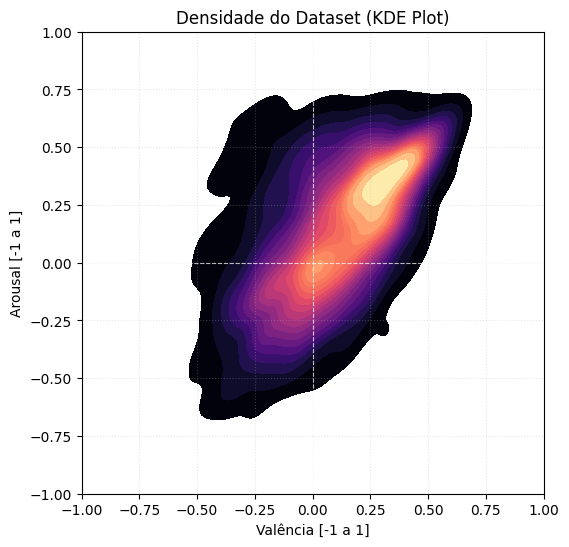

In [3]:
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=csv_data,
    x='valence',
    y='arousal',
    fill=True,
    cmap='magma',
    levels=20,
    thresh=0.02
)

# Adicionar linhas centrais, limites e rótulos
plt.axhline(0, color='white', linestyle='--', linewidth=0.8, alpha=0.7)
plt.axvline(0, color='white', linestyle='--', linewidth=0.8, alpha=0.7)
plt.title("Densidade do Dataset (KDE Plot)")
plt.xlabel("Valência [-1 a 1]")
plt.ylabel("Arousal [-1 a 1]")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, linestyle=':', alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

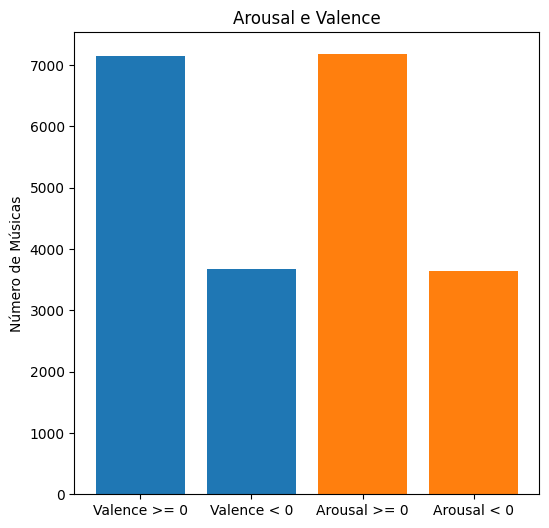

Quadrante 1 (Alegria): 5825 | 53.88%
Quadrante 2 (Calma): 1316 | 12.17%
Quadrante 3 (Tristeza): 2320 | 21.46%
Quadrante 4 (Raiva): 1351 | 12.50%


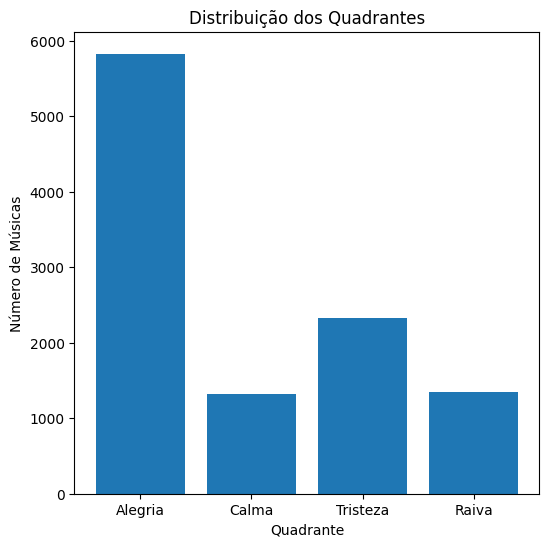

In [4]:
positive_valence = csv_data[(csv_data['valence'] > 0)]
negative_valence = csv_data[(csv_data['valence'] <= 0)]
positive_arousal = csv_data[(csv_data['arousal'] > 0)]
negative_arousal = csv_data[(csv_data['arousal'] <= 0)]

plt.figure(figsize=(6, 6))
plt.bar([1, 2], [len(positive_valence), len(negative_valence)])
plt.bar([3, 4], [len(positive_arousal), len(negative_arousal)])
plt.title("Arousal e Valence")
plt.ylabel("Número de Músicas")
plt.xticks([1, 2, 3, 4], ['Valence >= 0', 'Valence < 0', 'Arousal >= 0', 'Arousal < 0'])
plt.show()

quadrante_1 = csv_data[(csv_data['valence'] >= 0) & (csv_data['arousal'] > 0)]
quadrante_2 = csv_data[(csv_data['valence'] >= 0) & (csv_data['arousal'] <= 0)]
quadrante_3 = csv_data[(csv_data['valence'] < 0) & (csv_data['arousal'] <= 0)]
quadrante_4 = csv_data[(csv_data['valence'] < 0) & (csv_data['arousal'] > 0)]

print(f"Quadrante 1 (Alegria): {len(quadrante_1)} | {len(quadrante_1) / len(csv_data) * 100:.2f}%")
print(f"Quadrante 2 (Calma): {len(quadrante_2)} | {len(quadrante_2) / len(csv_data) * 100:.2f}%")
print(f"Quadrante 3 (Tristeza): {len(quadrante_3)} | {len(quadrante_3) / len(csv_data) * 100:.2f}%")
print(f"Quadrante 4 (Raiva): {len(quadrante_4)} | {len(quadrante_4) / len(csv_data) * 100:.2f}%")

plt.figure(figsize=(6, 6))
plt.bar([1, 2, 3, 4], [len(quadrante_1), len(quadrante_2), len(quadrante_3), len(quadrante_4)])
plt.title("Distribuição dos Quadrantes")
plt.xlabel("Quadrante")
plt.ylabel("Número de Músicas")
plt.xticks([1, 2, 3, 4], ['Alegria', 'Calma', 'Tristeza', 'Raiva'])
plt.show()

In [71]:
def pad_or_truncate_time(array_2d, target_length):
    # array_2d shape: (current_frames, n_features)
    current_length = array_2d.shape[0]
    n_features = array_2d.shape[1]
    if current_length == target_length:
        return array_2d

    if current_length < target_length:
        pad_width = target_length - current_length
        padded_array = np.pad(array_2d, ((0, pad_width), (0, 0)), mode='constant')
    else:
        padded_array = array_2d[:target_length, :] # Trunca os FRAMES
    return padded_array


In [72]:
SR = 22050
N_MFCC = 40
TARGET_LENGTH = 216
N_CHROMA = 12
N_CONTRAST_BANDS = 6
N_TONNETZ = 6
TOTAL_FEATURES = N_MFCC + 1 + 1 + (N_CONTRAST_BANDS + 1) + N_CHROMA + N_TONNETZ
# TOTAL_FEATURES = 40 + 1 + 1 + 7 + 12 + 6 = 67
print(f"Número total de features combinadas: {TOTAL_FEATURES}")

def load_and_process_features(file_path, sr=SR, n_mfcc=N_MFCC, n_chroma=N_CHROMA, n_contrast_bands=N_CONTRAST_BANDS, target_length=TARGET_LENGTH, total_features=TOTAL_FEATURES):
    try:
        y, sr_loaded = librosa.load(file_path, sr=sr)
        if len(y) == 0: return None

        mfcc = librosa.feature.mfcc(y=y, sr=sr_loaded, n_mfcc=n_mfcc)
        zcr = librosa.feature.zero_crossing_rate(y=y)
        bw = librosa.feature.spectral_bandwidth(y=y, sr=sr_loaded)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr_loaded, n_bands=n_contrast_bands)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr_loaded, n_chroma=n_chroma)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr_loaded)

        combined = np.hstack((
            mfcc.T,
            zcr.T,
            bw.T,
            contrast.T,
            chroma.T,
            tonnetz.T
        ))

        combined_padded = pad_or_truncate_time(combined, target_length)
        if combined_padded.shape == (target_length, total_features):
            return combined_padded
        else:
            return None
    except Exception as e:
        return None

features_list = []
labels_list = []

for _, row in csv_data.iterrows():
    audio_id = row['song_id']
    audio_path = f"DEAM_audio_split/{audio_id}.wav"
    if not os.path.exists(audio_path): continue

    features = load_and_process_features(audio_path)

    if features is not None:
        features_list.append(features)
        labels_list.append([row['arousal'], row['valence']])

print(f"Processamento concluído. {len(features_list)} amostras válidas carregadas.")

valid_indices = [i for i, f in enumerate(features_list) if f is not None and f.shape == (TARGET_LENGTH, TOTAL_FEATURES)]
if len(valid_indices) < len(features_list):
    print(f"Removendo {len(features_list) - len(valid_indices)} amostras com features inválidas.")
    features_list = [features_list[i] for i in valid_indices]
    labels_list = [labels_list[i] for i in valid_indices]

X = np.array(features_list, dtype=np.float32)
y = np.array(labels_list, dtype=np.float32)

print(f"Shape final de X: {X.shape}, Dtype: {X.dtype}")
print(f"Shape final de y: {y.shape}, Dtype: {y.dtype}")

Número total de features combinadas: 67


/Users/gabrielandrade/Code/ufba/tcc/.venv/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/Users/gabrielandrade/Code/ufba/tcc/.venv/lib/python3.9/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/gabrielandrade/Code/ufba/tcc/.venv/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=625
  warnings.warn(


Processamento concluído. 10812 amostras válidas carregadas.
Shape final de X: (10812, 216, 67), Dtype: float32
Shape final de y: (10812, 2), Dtype: float32


In [73]:
arousal_all = y[:, 0]
valence_all = y[:, 1]

# 1=Q1(Alegria), 2=Q2(Calma), 3=Q3(Tristeza), 4=Q4(Raiva)
y_quadrants = np.zeros(len(y), dtype=int) 
y_quadrants[(valence_all >= 0) & (arousal_all > 0)] = 1
y_quadrants[(valence_all >= 0) & (arousal_all <= 0)] = 2
y_quadrants[(valence_all < 0) & (arousal_all <= 0)] = 3
y_quadrants[(valence_all < 0) & (arousal_all > 0)] = 4


print(f"Rótulos de quadrante criados. Ex (primeiros 10): {y_quadrants[:10]}")
print(f"Contagem total: Q1={np.sum(y_quadrants == 1)}, Q2={np.sum(y_quadrants == 2)}, Q3={np.sum(y_quadrants == 3)}, Q4={np.sum(y_quadrants == 4)}")
print(f"Total samples: {len(y_quadrants)}")


Rótulos de quadrante criados. Ex (primeiros 10): [1 3 4 1 1 3 2 1 1 1]
Contagem total: Q1=5825, Q2=1316, Q3=2320, Q4=1351
Total samples: 10812


In [74]:
input_shape = (TARGET_LENGTH, TOTAL_FEATURES)
cnn_input = layers.Input(shape=input_shape, name="Input")
x = layers.Conv1D(32, 3, activation='relu')(cnn_input)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv1D(64, 3, activation='relu')(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.3)(x)
cnn_base_output = x

cnn_base_model = keras.Model(inputs=cnn_input, outputs=cnn_base_output, name="CNN_Base")
cnn_base_model.summary()

#  LSTM
lstm_input = layers.Input(shape=input_shape, name="LSTM_Input")
x = cnn_base_model(lstm_input)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), name="BiLSTM_1")(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3), name="BiLSTM_2")(x)
x = layers.Dropout(0.4)(x)


lstm_output = layers.Dense(2, activation='tanh', name='output')(x)

model_lstm = keras.Model(inputs=lstm_input, outputs=lstm_output, name="Bidirectional_LSTM_Model")
model_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                   loss='mse',
                   metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')])

print("\nSumário Modelo LSTM Bidirecional com Dropout")
model_lstm.summary()

Model: "CNN_Base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 216, 67)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 214, 32)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 107, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 107, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 105, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 103, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 51, 128)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,376 (146.00 KB)

 Trainable params: 37,376 (146.00 KB)

 Non-trainable params: 0 (0.00 B)


Sumário Modelo LSTM Bidirecional com Dropout


Model: "Bidirectional_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Input (InputLayer)         │ (None, 216, 67)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Base (Functional)           │ (None, 51, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_1 (Bidirectional)        │ (None, 51, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_2 (Bidirectional)        │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,538 (693.51 KB)

 Trainable params: 177,538 (693.51 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# GRU
gru_input = layers.Input(shape=input_shape, name="GRU_Input")
x = cnn_base_model(gru_input)

# Bidirectional GRU + Dropout
x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), name="BiGRU_1")(x)
x = layers.Bidirectional(layers.GRU(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3), name="BiGRU_2")(x)
x = layers.Dropout(0.4)(x)

gru_output = layers.Dense(2, activation='tanh', name='output')(x)

model_gru = keras.Model(inputs=gru_input, outputs=gru_output, name="Bidirectional_GRU_Model")
model_gru.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss='mse',
                  metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')])

print("\nSumário Modelo GRU Bidirecional com Dropout")
model_gru.summary()


Sumário Modelo GRU Bidirecional com Dropout


Model: "Bidirectional_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_Input (InputLayer)          │ (None, 216, 67)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Base (Functional)           │ (None, 51, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiGRU_1 (Bidirectional)         │ (None, 51, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiGRU_2 (Bidirectional)         │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,106 (559.01 KB)

 Trainable params: 143,106 (559.01 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from sklearn.model_selection import StratifiedKFold
LEARNING_RATE = 0.0005
EPOCHS = 50
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 10
N_SPLITS = 5
RANDOM_SEED = 42

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
rng = np.random.RandomState(RANDOM_SEED)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

def train_model_kfold(model, X, y):
    fold_num = 1
    for train_index, val_index in skf.split(X, y_quadrants):
        print("-" * 50)
        print(f"Processando Fold {fold_num}/{N_SPLITS}...")

        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        print(f"  Treino: {len(X_train_fold)} amostras, Validação: {len(X_val_fold)} amostras")

        scaler_x_fold = StandardScaler()
        original_shape_train_fold = X_train_fold.shape
        num_features = original_shape_train_fold[-1]
        X_train_fold_reshaped = X_train_fold.reshape(-1, num_features)
        
        scaler_x_fold.fit(X_train_fold_reshaped)
        
        X_train_fold_scaled_reshaped = scaler_x_fold.transform(X_train_fold_reshaped)
        
        original_shape_val_fold = X_val_fold.shape
        X_val_fold_reshaped = X_val_fold.reshape(-1, num_features)
        X_val_fold_scaled_reshaped = scaler_x_fold.transform(X_val_fold_reshaped)
        
        X_train_fold_scaled = X_train_fold_scaled_reshaped.reshape(original_shape_train_fold)
        X_val_fold_scaled = X_val_fold_scaled_reshaped.reshape(original_shape_val_fold)
        print("  StandardScaler ajustado e aplicado para o fold.")

        arousal_train_fold = y_train_fold[:, 0]
        valence_train_fold = y_train_fold[:, 1]
        q1_mask = (valence_train_fold >= 0) & (arousal_train_fold > 0)
        q2_mask = (valence_train_fold >= 0) & (arousal_train_fold <= 0)
        q3_mask = (valence_train_fold < 0) & (arousal_train_fold <= 0)
        q4_mask = (valence_train_fold < 0) & (arousal_train_fold > 0)
        n_samples_train_fold = len(y_train_fold)
        n_q1 = max(np.sum(q1_mask), 1e-6)
        n_q2 = max(np.sum(q2_mask), 1e-6)
        n_q3 = max(np.sum(q3_mask), 1e-6)
        n_q4 = max(np.sum(q4_mask), 1e-6)
        num_quadrants = 4
        weight_q1 = n_samples_train_fold / (num_quadrants * n_q1)
        weight_q2 = n_samples_train_fold / (num_quadrants * n_q2)
        weight_q3 = n_samples_train_fold / (num_quadrants * n_q3)
        weight_q4 = n_samples_train_fold / (num_quadrants * n_q4)
        sample_weights_fold = np.zeros(n_samples_train_fold, dtype=np.float32)
        sample_weights_fold[q1_mask] = weight_q1
        sample_weights_fold[q2_mask] = weight_q2
        sample_weights_fold[q3_mask] = weight_q3
        sample_weights_fold[q4_mask] = weight_q4
        print(f"  Pesos calculados para o fold: Q1={weight_q1:.2f}, Q2={weight_q2:.2f}, Q3={weight_q3:.2f}, Q4={weight_q4:.2f}")

        model_fold = model
        print(f"  Modelo '{model_fold.name}' criado para o fold.")

        # 5. Definir Callbacks para o fold
        early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=EARLY_STOPPING_PATIENCE,
                                    restore_best_weights=True,
                                    verbose=1)
        callbacks_fold = [early_stopping]

        print(f"  Iniciando treinamento do Fold {fold_num}...")
        history = model_fold.fit(
            X_train_fold_scaled, y_train_fold,
            validation_data=(X_val_fold_scaled, y_val_fold),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            sample_weight=sample_weights_fold,
            callbacks=callbacks_fold,
            verbose=2
        )

        print(f"  Avaliando Fold {fold_num} no conjunto de validação...")
        scores = model_fold.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)
        print(f"  Fold {fold_num} - Val Loss (MSE): {scores[0]:.4f}, Val MAE: {scores[1]:.4f}, Val RMSE: {scores[2]:.4f}")

        fold_val_loss_scores[model.name].append(scores[0])
        fold_val_mae_scores[model.name].append(scores[1])
        fold_val_rmse_scores[model.name].append(scores[2])

        keras.backend.clear_session()
        del model_fold
        del scaler_x_fold

        fold_num += 1
    
models = [model_lstm, model_gru]
fold_val_loss_scores = {}
fold_val_mae_scores = {}
fold_val_rmse_scores = {}
for model in models:
    print(f"\nTreinando modelo: {model.name}")
    # Resetar listas de métricas para cada modelo
    fold_val_loss_scores[model.name] = []
    fold_val_mae_scores[model.name] = []
    fold_val_rmse_scores[model.name] = []

    train_model_kfold(model, X, y)


Treinando modelo: Bidirectional_LSTM_Model
--------------------------------------------------
Processando Fold 1/5...
  Treino: 8649 amostras, Validação: 2163 amostras
  StandardScaler ajustado e aplicado para o fold.
  Pesos calculados para o fold: Q1=0.46, Q2=2.05, Q3=1.17, Q4=2.00
  Modelo 'Bidirectional_LSTM_Model' criado para o fold.
  Iniciando treinamento do Fold 1...
Epoch 1/50
271/271 - 31s - 113ms/step - loss: 0.0222 - mae: 0.1270 - rmse: 0.1600 - val_loss: 0.0218 - val_mae: 0.1169 - val_rmse: 0.1475
Epoch 2/50
271/271 - 28s - 105ms/step - loss: 0.0214 - mae: 0.1251 - rmse: 0.1583 - val_loss: 0.0204 - val_mae: 0.1127 - val_rmse: 0.1427
Epoch 3/50
271/271 - 28s - 103ms/step - loss: 0.0213 - mae: 0.1247 - rmse: 0.1579 - val_loss: 0.0244 - val_mae: 0.1240 - val_rmse: 0.1562
Epoch 4/50
271/271 - 29s - 105ms/step - loss: 0.0209 - mae: 0.1238 - rmse: 0.1568 - val_loss: 0.0207 - val_mae: 0.1134 - val_rmse: 0.1437
Epoch 5/50
271/271 - 28s - 104ms/step - loss: 0.0205 - mae: 0.1229 - 

Preparando estratificação...
Contagem de classes para estratificação: [5825 1316 2320 1351]

Iniciando Validação Cruzada para: CNN_BiLSTM
--> Processando Fold 1/5... Concluído.
--> Processando Fold 2/5... Concluído.
--> Processando Fold 3/5... Concluído.
--> Processando Fold 4/5... Concluído.
--> Processando Fold 5/5... Concluído.

Iniciando Validação Cruzada para: CNN_BiGRU
--> Processando Fold 1/5... Concluído.
--> Processando Fold 2/5... Concluído.
--> Processando Fold 3/5... Concluído.
--> Processando Fold 4/5... Concluído.
--> Processando Fold 5/5... Concluído.

Gerando gráficos comparativos...


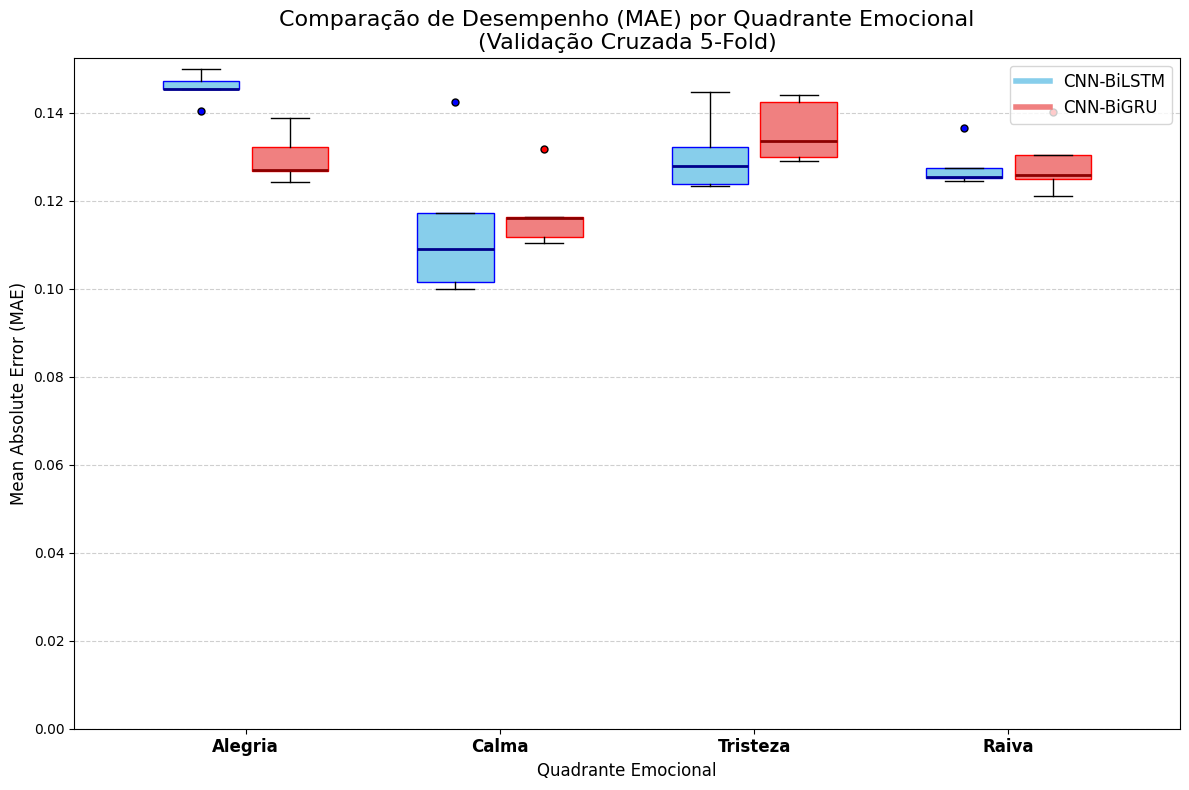


--- Médias de MAE por Quadrante ---
Quadrante  | LSTM       | GRU       
-----------------------------------
Alegria    | 0.1458     | 0.1299
Calma      | 0.1141     | 0.1173
Tristeza   | 0.1304     | 0.1358
Raiva      | 0.1278     | 0.1286


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import os

# ==============================================================================
# 1. CONFIGURAÇÕES E PARÂMETROS
# ==============================================================================
# Parâmetros de Áudio/Features
SR = 22050
TARGET_LENGTH_FRAMES = 216
N_MFCC = 40
N_CHROMA = 12
N_CONTRAST_BANDS = 6
N_TONNETZ = 6
TOTAL_FEATURES = N_MFCC + 1 + 1 + (N_CONTRAST_BANDS + 1) + N_CHROMA + N_TONNETZ # 67
INPUT_SHAPE = (TARGET_LENGTH_FRAMES, TOTAL_FEATURES)

# Parâmetros de Treinamento
LEARNING_RATE = 0.0005
EPOCHS = 50
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 10
N_SPLITS = 5
RANDOM_SEED = 42

# Configuração de ambiente
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Reduz logs do TF
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ==============================================================================
# 2. DEFINIÇÃO DAS ARQUITETURAS DOS MODELOS
# ==============================================================================

def get_cnn_base(input_shape):
    """Cria a base CNN compartilhada."""
    cnn_input = layers.Input(shape=input_shape, name="Input")
    
    # Bloco 1
    x = layers.Conv1D(32, 3, activation='relu')(cnn_input)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloco 2
    x = layers.Conv1D(64, 3, activation='relu')(x)
    
    # Bloco 3
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    return keras.Model(inputs=cnn_input, outputs=x, name="CNN_Base")

def build_model_lstm(input_shape=INPUT_SHAPE, learning_rate=LEARNING_RATE):
    """Constrói e compila o modelo CNN-BiLSTM."""
    base_cnn = get_cnn_base(input_shape)
    
    model_input = layers.Input(shape=input_shape, name="LSTM_Input")
    x = base_cnn(model_input)
    
    # Camadas Recorrentes
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0), name="BiLSTM_1")(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.0), name="BiLSTM_2")(x)
    x = layers.Dropout(0.4)(x)
    
    # Saída
    output = layers.Dense(2, activation='tanh', name='output')(x)
    
    model = keras.Model(inputs=model_input, outputs=output, name="CNN_BiLSTM")
    
    # Otimizador com clipnorm para evitar NaN
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

def build_model_gru(input_shape=INPUT_SHAPE, learning_rate=LEARNING_RATE):
    """Constrói e compila o modelo CNN-BiGRU."""
    base_cnn = get_cnn_base(input_shape)
    
    model_input = layers.Input(shape=input_shape, name="GRU_Input")
    x = base_cnn(model_input)
    
    # Camadas Recorrentes
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0), name="BiGRU_1")(x)
    x = layers.Bidirectional(layers.GRU(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.0), name="BiGRU_2")(x)
    x = layers.Dropout(0.4)(x)
    
    # Saída
    output = layers.Dense(2, activation='tanh', name='output')(x)
    
    model = keras.Model(inputs=model_input, outputs=output, name="CNN_BiGRU")
    
    # Otimizador com clipnorm para evitar NaN
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Lista de construtores de modelo para iterar
model_builders = [build_model_lstm, build_model_gru]

# ==============================================================================
# 3. PREPARAÇÃO PARA ESTRATIFICAÇÃO
# ==============================================================================

print("Preparando estratificação...")
# Criar rótulos discretos de quadrante apenas para o K-Fold (1, 2, 3, 4)
# Q1: V>=0, A>0 | Q2: V>=0, A<=0 | Q3: V<0, A<=0 | Q4: V<0, A>0
arousal_all = y[:, 0]
valence_all = y[:, 1]
y_quadrants = np.zeros(len(y), dtype=int)
y_quadrants[(valence_all >= 0) & (arousal_all > 0)] = 1
y_quadrants[(valence_all >= 0) & (arousal_all <= 0)] = 2
y_quadrants[(valence_all < 0) & (arousal_all <= 0)] = 3
y_quadrants[(valence_all < 0) & (arousal_all > 0)] = 4

print("Contagem de classes para estratificação:", np.bincount(y_quadrants)[1:])

# ==============================================================================
# 4. LOOP DE TREINAMENTO K-FOLD
# ==============================================================================

# Estrutura para armazenar resultados: results[nome_modelo][nome_quadrante] = [lista de MAEs]
quadrant_names = ['Alegria', 'Calma', 'Tristeza', 'Raiva']
results_data = {
    'CNN_BiLSTM': {q: [] for q in quadrant_names},
    'CNN_BiGRU': {q: [] for q in quadrant_names}
}

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

for build_function in model_builders:
    # Instancia temporária para pegar o nome
    temp_model = build_function()
    model_name = temp_model.name
    del temp_model
    
    print(f"\n{'='*60}\nIniciando Validação Cruzada para: {model_name}\n{'='*60}")
    
    fold_num = 1
    for train_index, val_index in skf.split(X, y_quadrants):
        print(f"--> Processando Fold {fold_num}/{N_SPLITS}...", end=" ")
        
        # A. Divisão dos Dados
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # B. Normalização (StandardScaler) - Ajustado APENAS no treino
        scaler = StandardScaler()
        # Reshape para 2D, fit, transform, reshape de volta para 3D
        X_train_fold = scaler.fit_transform(X_train_fold.reshape(-1, TOTAL_FEATURES)).reshape(X_train_fold.shape)
        X_val_fold = scaler.transform(X_val_fold.reshape(-1, TOTAL_FEATURES)).reshape(X_val_fold.shape)
        
        # C. Cálculo de Sample Weights (Balanceamento)
        # Baseado apenas em y_train_fold
        a_train, v_train = y_train_fold[:, 0], y_train_fold[:, 1]
        # Máscaras
        m_q1 = (v_train >= 0) & (a_train > 0)
        m_q2 = (v_train >= 0) & (a_train <= 0)
        m_q3 = (v_train < 0) & (a_train <= 0)
        m_q4 = (v_train < 0) & (a_train > 0)
        
        counts = [np.sum(m_q1), np.sum(m_q2), np.sum(m_q3), np.sum(m_q4)]
        total_train = len(y_train_fold)
        # Pesos inversamente proporcionais
        weights_per_class = [total_train / (4 * max(c, 1)) for c in counts]
        
        sample_weights = np.zeros(total_train, dtype=np.float32)
        sample_weights[m_q1] = weights_per_class[0]
        sample_weights[m_q2] = weights_per_class[1]
        sample_weights[m_q3] = weights_per_class[2]
        sample_weights[m_q4] = weights_per_class[3]
        
        # D. Construção e Treinamento do Modelo
        keras.backend.clear_session() # Limpar memória da GPU/RAM
        model = build_function()
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=0
        )
        
        model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            sample_weight=sample_weights,
            callbacks=[early_stopping],
            verbose=0 # Silencioso para não poluir o output
        )
        
        # E. Avaliação Detalhada por Quadrante
        y_pred_fold = model.predict(X_val_fold, verbose=0)
        
        # Separar dados de validação por quadrante
        v_val, a_val = y_val_fold[:, 1], y_val_fold[:, 0]
        
        quadrant_masks = {
            'Alegria': (v_val >= 0) & (a_val > 0),
            'Calma':   (v_val >= 0) & (a_val <= 0),
            'Tristeza':(v_val < 0)  & (a_val <= 0),
            'Raiva':   (v_val < 0)  & (a_val > 0)
        }
        
        for q_name, mask in quadrant_masks.items():
            if np.sum(mask) > 0:
                mae = mean_absolute_error(y_val_fold[mask], y_pred_fold[mask])
                results_data[model_name][q_name].append(mae)
            else:
                # Caso raro de um quadrante não existir na validação
                results_data[model_name][q_name].append(np.nan)
        
        print("Concluído.")
        fold_num += 1

# ==============================================================================
# 5. PLOTAGEM DOS GRÁFICOS COMPARATIVOS (BOXPLOT LADO A LADO)
# ==============================================================================



Gerando gráficos comparativos e tabelas...


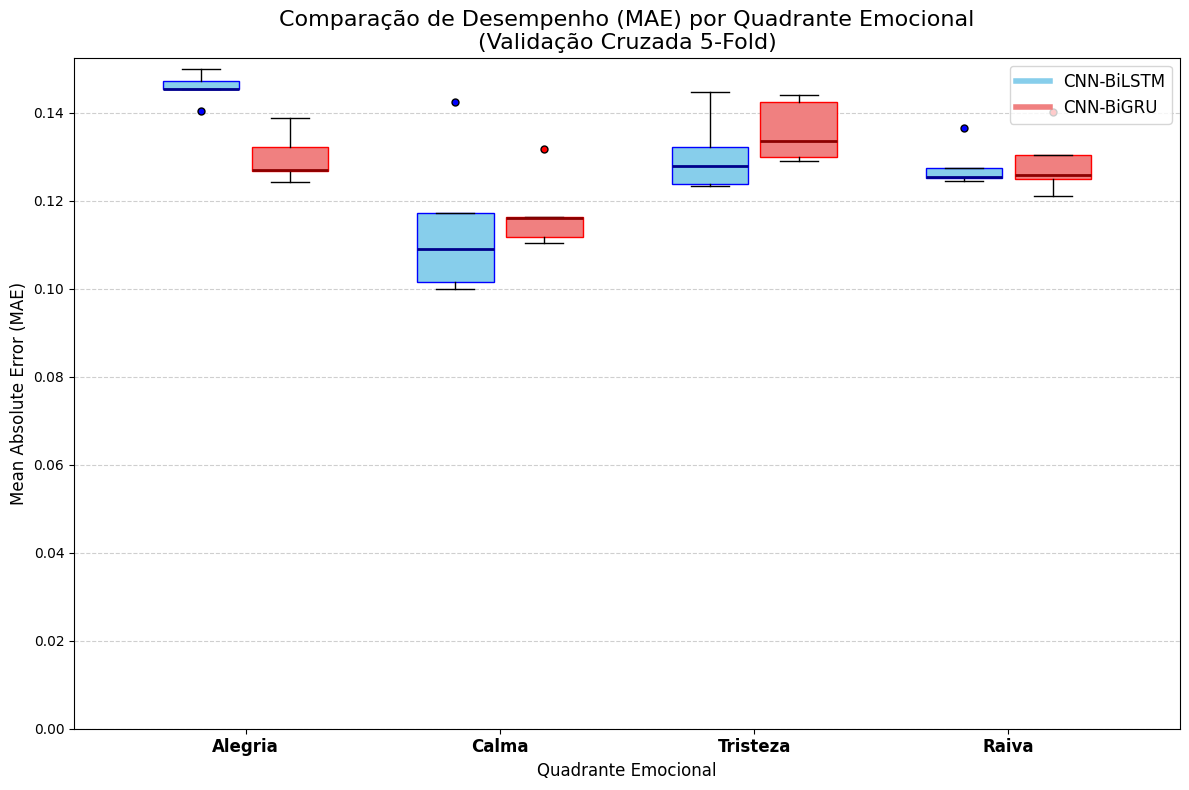


                   RESULTADOS DETALHADOS POR QUADRANTE (MAE)                    
Métrica / Quadrante       | CNN-BiLSTM                | CNN-BiGRU                
--------------------------------------------------------------------------------
Alegria                   | 0.1458 (+/- 0.0031)    | 0.1299 (+/- 0.0052)
Calma                     | 0.1141 (+/- 0.0155)    | 0.1173 (+/- 0.0077)
Tristeza                  | 0.1304 (+/- 0.0078)    | 0.1358 (+/- 0.0063)
Raiva                     | 0.1278 (+/- 0.0045)    | 0.1286 (+/- 0.0065)
--------------------------------------------------------------------------------
GERAL (Média dos Folds)   | 0.1295 (+/- 0.0144)    | 0.1279 (+/- 0.0093)

Obs: 'GERAL' aqui representa a média e desvio padrão agregados de todos os scores de MAE individuais coletados nos 5 folds.


In [ ]:

print("\nGerando gráficos comparativos e tabelas...")

lstm_data = [results_data['CNN_BiLSTM'][q] for q in quadrant_names]
gru_data = [results_data['CNN_BiGRU'][q] for q in quadrant_names]

fig, ax = plt.subplots(figsize=(12, 8))

x_pos = np.arange(len(quadrant_names))
width = 0.35

bp1 = ax.boxplot(lstm_data, positions=x_pos - width/2, widths=0.3, patch_artist=True,
                 boxprops=dict(facecolor="skyblue", color="blue"),
                 medianprops=dict(color="darkblue", linewidth=2),
                 flierprops=dict(marker='o', markerfacecolor='blue', markersize=5))

bp2 = ax.boxplot(gru_data, positions=x_pos + width/2, widths=0.3, patch_artist=True,
                 boxprops=dict(facecolor="lightcoral", color="red"),
                 medianprops=dict(color="darkred", linewidth=2),
                 flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

ax.set_title('Comparação de Desempenho (MAE) por Quadrante Emocional\n(Validação Cruzada 5-Fold)', fontsize=16)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.set_xlabel('Quadrante Emocional', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(quadrant_names, fontsize=12, fontweight='bold')

ax.grid(True, linestyle='--', alpha=0.6, axis='y')
ax.set_ylim(bottom=0)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='skyblue', lw=4, label='CNN-BiLSTM'),
    Line2D([0], [0], color='lightcoral', lw=4, label='CNN-BiGRU')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"{'RESULTADOS DETALHADOS POR QUADRANTE (MAE)':^80}")
print("="*80)
print(f"{'Métrica / Quadrante':<25} | {'CNN-BiLSTM':<25} | {'CNN-BiGRU':<25}")
print("-" * 80)

for i, q in enumerate(quadrant_names):
    # LSTM
    lstm_vals = np.array(lstm_data[i])
    mean_lstm = np.nanmean(lstm_vals)
    std_lstm = np.nanstd(lstm_vals)
    
    # GRU
    gru_vals = np.array(gru_data[i])
    mean_gru = np.nanmean(gru_vals)
    std_gru = np.nanstd(gru_vals)
    
    print(f"{q:<25} | {mean_lstm:.4f} (+/- {std_lstm:.4f})    | {mean_gru:.4f} (+/- {std_gru:.4f})")

print("-" * 80)

all_lstm_vals = np.concatenate([np.array(d) for d in lstm_data if len(d) > 0])
all_gru_vals = np.concatenate([np.array(d) for d in gru_data if len(d) > 0])

mean_global_lstm = np.nanmean(all_lstm_vals)
std_global_lstm = np.nanstd(all_lstm_vals)

mean_global_gru = np.nanmean(all_gru_vals)
std_global_gru = np.nanstd(all_gru_vals)

print(f"{'GERAL (Média dos Folds)':<25} | {mean_global_lstm:.4f} (+/- {std_global_lstm:.4f})    | {mean_global_gru:.4f} (+/- {std_global_gru:.4f})")
print("="*80)
print("\nObs: 'GERAL' aqui representa a média e desvio padrão agregados de todos os scores de MAE individuais coletados nos 5 folds.")

Médias LSTM extraídas: [np.float64(0.1457585096359253), np.float64(0.11410946696996689), np.float64(0.13044083267450332), np.float64(0.12780208587646485)]
Std LSTM extraído: [np.float64(0.003126403371347684), np.float64(0.015451564105121841), np.float64(0.007811944448747875), np.float64(0.004501895701763177)]
Médias GRU extraídas: [np.float64(0.129908387362957), np.float64(0.11731376349925995), np.float64(0.1358410030603409), np.float64(0.12856511473655702)]
Std GRU extraído: [np.float64(0.005221425306987273), np.float64(0.0076500146785427655), np.float64(0.006282438047874105), np.float64(0.006534465172789837)]


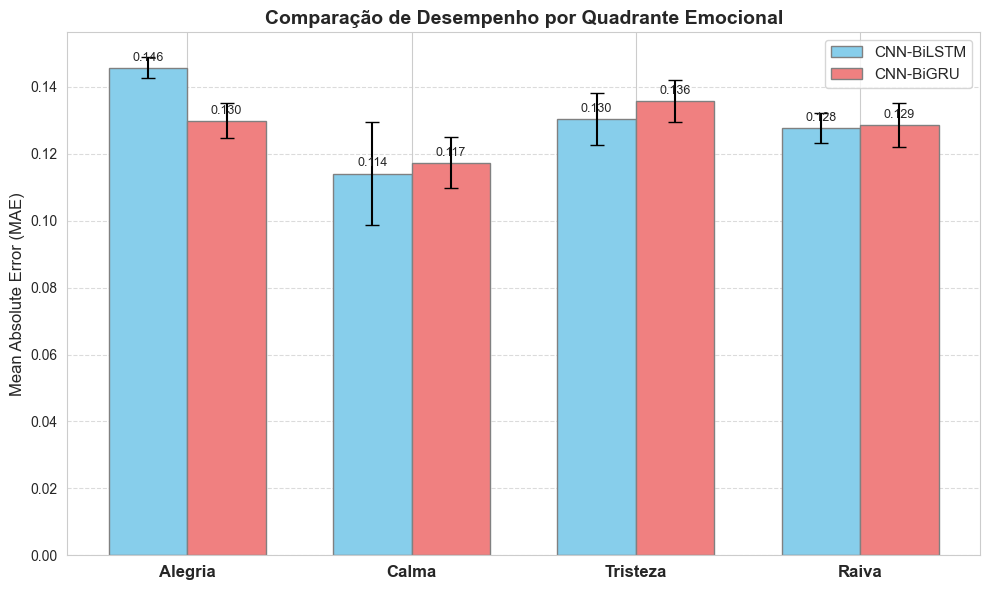

In [90]:
quadrant_labels = ['Alegria', 'Calma', 'Tristeza', 'Raiva']
# -----------------------------------------------------------
# 1. Inicializar as listas vazias
lstm_mae_means = []
lstm_mae_std = []
gru_mae_means = []
gru_mae_std = []

# 2. Iterar pelos dados para calcular média e desvio padrão
for i in range(len(quadrant_names)):
    # --- LSTM ---
    # Pega os valores dos 5 folds para o quadrante 'i'
    vals_lstm = np.array(lstm_data[i])
    # Calcula média e desvio padrão (usando nanmean para ignorar NaNs se houver)
    lstm_mae_means.append(np.nanmean(vals_lstm))
    lstm_mae_std.append(np.nanstd(vals_lstm))
    
    # --- GRU ---
    # Pega os valores dos 5 folds para o quadrante 'i'
    vals_gru = np.array(gru_data[i])
    # Calcula média e desvio padrão
    gru_mae_means.append(np.nanmean(vals_gru))
    gru_mae_std.append(np.nanstd(vals_gru))

# 3. Verificar os valores extraídos (opcional)
print("Médias LSTM extraídas:", lstm_mae_means)
print("Std LSTM extraído:", lstm_mae_std)
print("Médias GRU extraídas:", gru_mae_means)
print("Std GRU extraído:", gru_mae_std)

def plot_comparative_mae_bars(lstm_means, gru_means, lstm_std=None, gru_std=None, labels=quadrant_labels):
    """
    Plota um gráfico de barras agrupado comparando o MAE de dois modelos por quadrante.
    """
    
    # Configurações do gráfico
    x = np.arange(len(labels))  # Posições dos rótulos no eixo X
    width = 0.35  # Largura das barras

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotar barras LSTM (deslocadas para a esquerda)
    rects1 = ax.bar(x - width/2, lstm_means, width, label='CNN-BiLSTM', 
                    yerr=lstm_std, capsize=5, color='skyblue', edgecolor='grey')

    # Plotar barras GRU (deslocadas para a direita)
    rects2 = ax.bar(x + width/2, gru_means, width, label='CNN-BiGRU', 
                    yerr=gru_std, capsize=5, color='lightcoral', edgecolor='grey')

    # Adicionar textos, rótulos e título
    ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
    ax.set_title('Comparação de Desempenho por Quadrante Emocional', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax.legend(fontsize=11)

    # Adicionar grade horizontal para facilitar a leitura
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True) # Coloca a grade atrás das barras

    # Função para adicionar rótulos de valor acima das barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 pontos de deslocamento vertical
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()
    
plot_comparative_mae_bars(lstm_mae_means, gru_mae_means, lstm_mae_std, gru_mae_std)

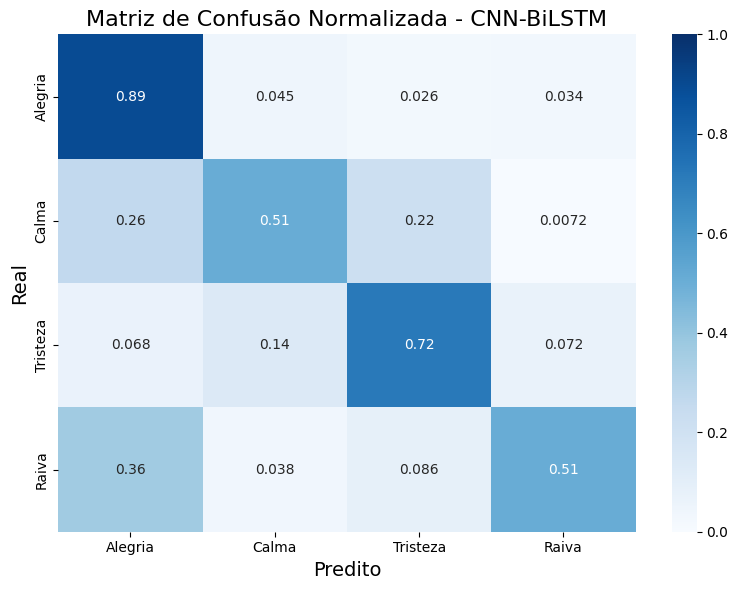

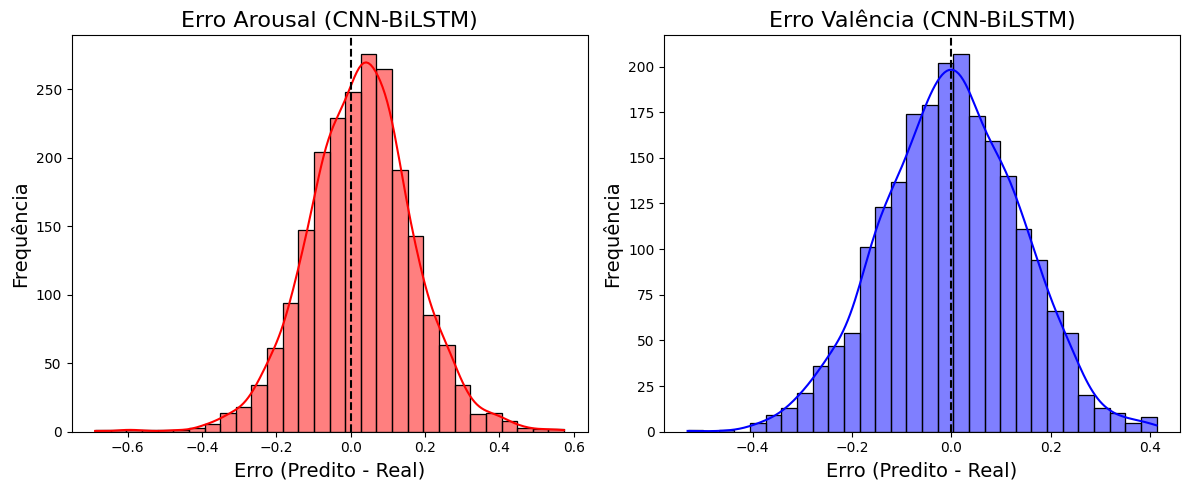

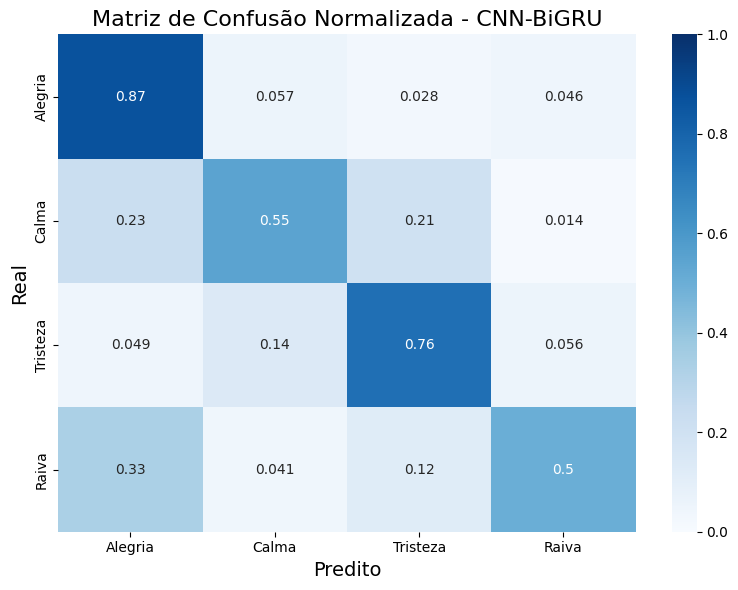

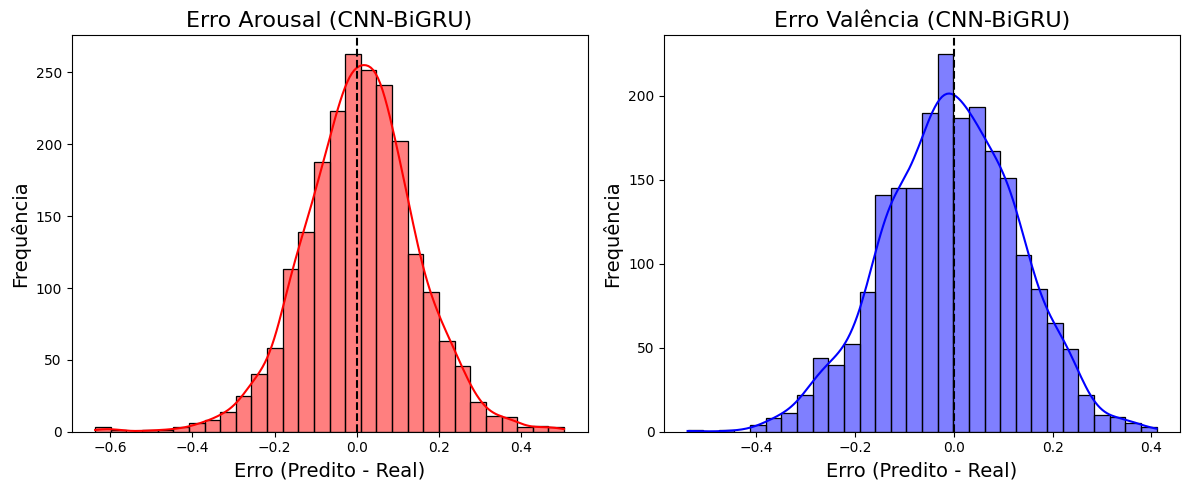

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Função Auxiliar para Discretizar em Quadrantes ---
def get_quadrant(arousal, valence):
    # 0: Alegria (Q1), 1: Calma (Q2), 2: Tristeza (Q3), 3: Raiva (Q4)
    q = np.zeros_like(arousal, dtype=int)
    q[(valence >= 0) & (arousal > 0)] = 0 # Alegria
    q[(valence >= 0) & (arousal <= 0)] = 1 # Calma
    q[(valence < 0) & (arousal <= 0)] = 2 # Tristeza
    q[(valence < 0) & (arousal > 0)] = 3 # Raiva
    return q

# --- 1. Matriz de Confusão ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plota a matriz de confusão normalizada.
    y_true: Array com valores reais [arousal, valence]
    y_pred: Array com valores previstos [arousal, valence]
    """
    q_true = get_quadrant(y_true[:, 0], y_true[:, 1])
    q_pred = get_quadrant(y_pred[:, 0], y_pred[:, 1])
    
    # Calcular matriz de confusão
    # labels=[0, 1, 2, 3] garante que todos os quadrantes apareçam mesmo se não houver dados em algum
    cm = confusion_matrix(q_true, q_pred, labels=[0, 1, 2, 3])
    
    # Normalizar por linha (true class) para ter porcentagens
    # Adiciona 1e-10 para evitar divisão por zero se uma classe não tiver amostras
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)
    
    labels = ['Alegria', 'Calma', 'Tristeza', 'Raiva']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    plt.title(f'Matriz de Confusão Normalizada - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

# --- 2. Histogramas de Erro (Resíduos) ---
def plot_error_histograms(y_true, y_pred, model_name):
    """
    Plota histogramas dos erros de predição (resíduos).
    """
    errors_arousal = y_pred[:, 0] - y_true[:, 0]
    errors_valence = y_pred[:, 1] - y_true[:, 1]
    
    plt.figure(figsize=(12, 5))
    
    # Arousal
    plt.subplot(1, 2, 1)
    sns.histplot(errors_arousal, kde=True, color='red', bins=30)
    plt.title(f'Erro Arousal ({model_name})')
    plt.xlabel('Erro (Predito - Real)')
    plt.ylabel('Frequência')
    plt.axvline(0, color='black', linestyle='--') # Linha zero

    # Valence
    plt.subplot(1, 2, 2)
    sns.histplot(errors_valence, kde=True, color='blue', bins=30)
    plt.title(f'Erro Valência ({model_name})')
    plt.xlabel('Erro (Predito - Real)')
    plt.ylabel('Frequência')
    plt.axvline(0, color='black', linestyle='--') # Linha zero
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_val, model_lstm.predict(X_val, verbose=0), "CNN-BiLSTM")
plot_error_histograms(y_val, model_lstm.predict(X_val, verbose=0), "CNN-BiLSTM")
plot_confusion_matrix(y_val, model_gru.predict(X_val, verbose=0), "CNN-BiGRU")
plot_error_histograms(y_val, model_gru.predict(X_val, verbose=0), "CNN-BiGRU")

------------------------------------------------------------
[<Functional name=Bidirectional_LSTM_Model, built=True>, <Functional name=Bidirectional_GRU_Model, built=True>]
Resultados Médios para o modelo Bidirectional_LSTM_Model:
[0.020357420668005943, 0.01946776919066906, 0.01917308196425438, 0.019915051758289337, 0.01878264918923378]
[0.11274944990873337, 0.10876794904470444, 0.10842888057231903, 0.11126831918954849, 0.1080559641122818]
[0.14267943799495697, 0.13952694833278656, 0.13846689462661743, 0.14112070202827454, 0.1370498090982437]
  Loss (MSE) Média : 0.0195 (+/- 0.0006)
  MAE Médio        : 0.1099 (+/- 0.0018)
  RMSE Médio       : 0.1398 (+/- 0.0020)
------------------------------------------------------------


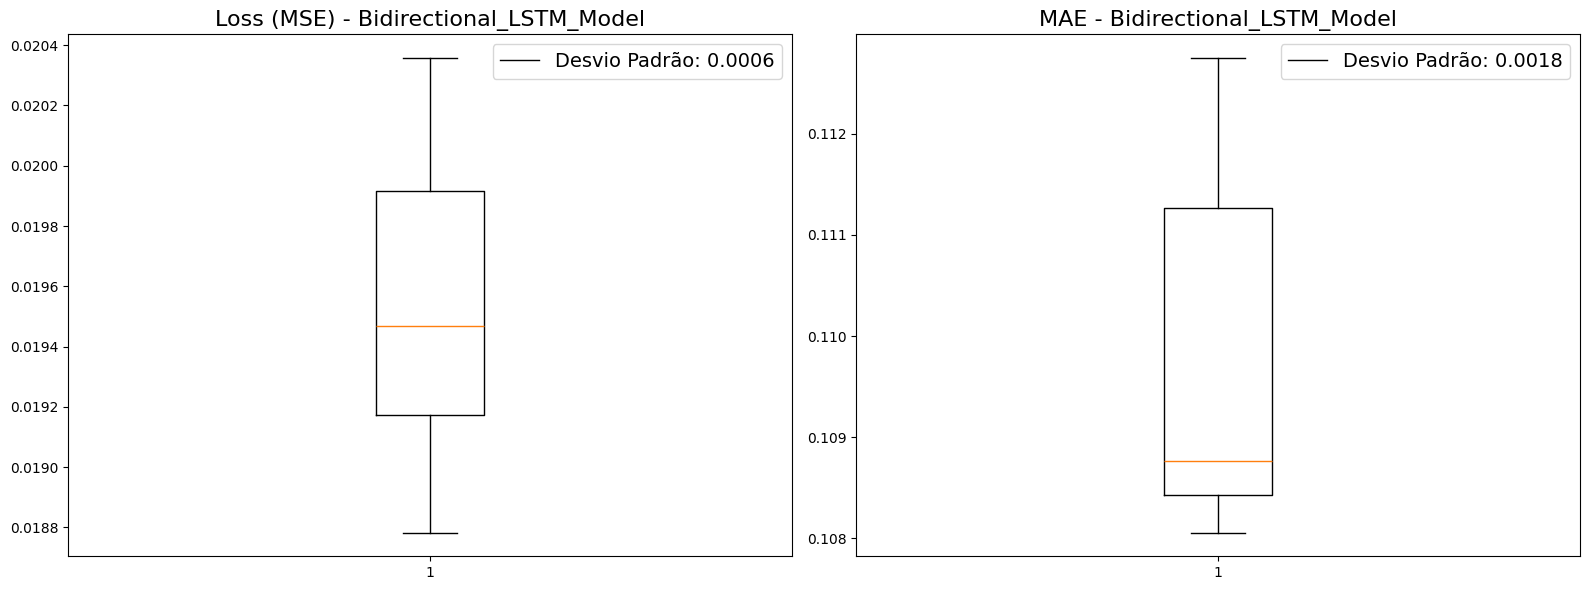

Resultados Médios para o modelo Bidirectional_GRU_Model:
[0.018848571926355362, 0.018580984324216843, 0.016909655183553696, 0.017561443150043488, 0.01656261458992958]
[0.10818573832511902, 0.107207290828228, 0.10137764364480972, 0.10455173999071121, 0.10128477215766907]
[0.1372901052236557, 0.1363120824098587, 0.1300371289253235, 0.13251960277557373, 0.12869581580162048]
  Loss (MSE) Média : 0.0177 (+/- 0.0009)
  MAE Médio        : 0.1045 (+/- 0.0029)
  RMSE Médio       : 0.1330 (+/- 0.0034)
------------------------------------------------------------


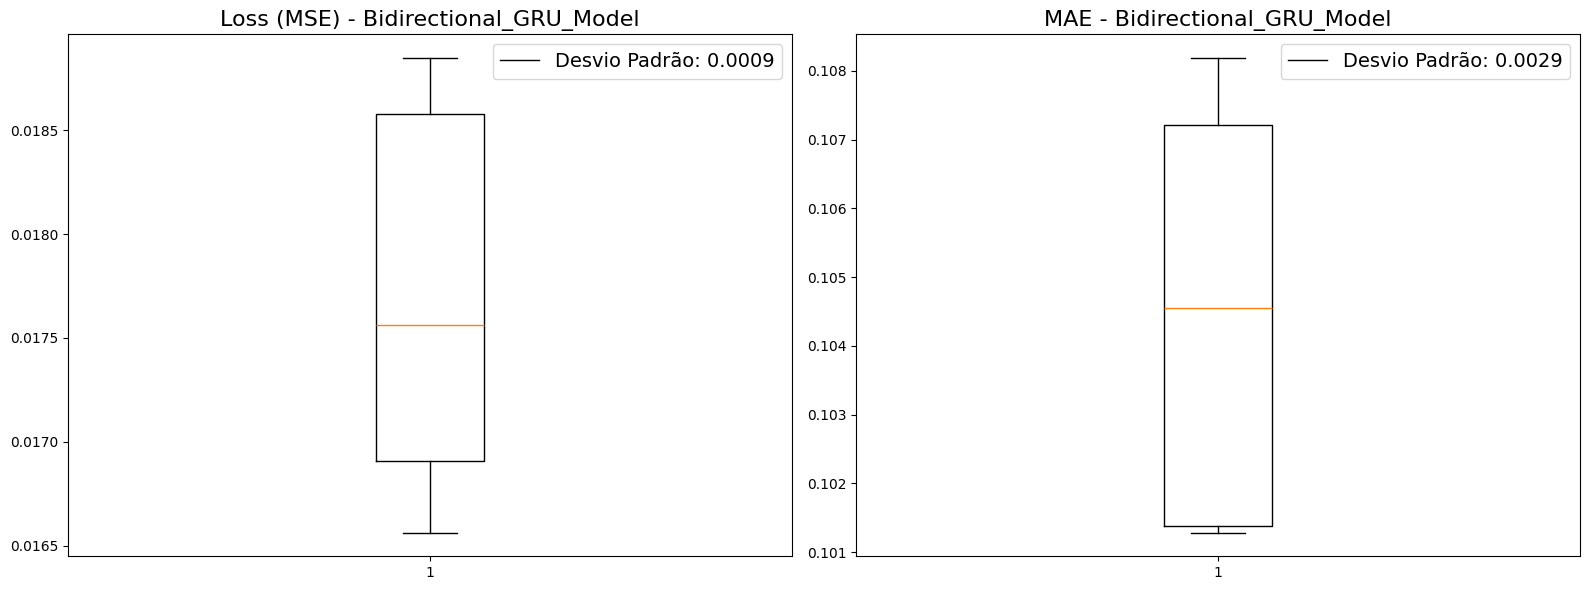

In [33]:
print("-" * 60)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 14
print(models)
for model in models:
    print(f"Resultados Médios para o modelo {model.name}:")
    print(fold_val_loss_scores[model.name])
    print(fold_val_mae_scores[model.name])
    print(fold_val_rmse_scores[model.name])
    print(f"  Loss (MSE) Média : {np.mean(fold_val_loss_scores[model.name]):.4f} (+/- {np.std(fold_val_loss_scores[model.name]):.4f})")
    print(f"  MAE Médio        : {np.mean(fold_val_mae_scores[model.name]):.4f} (+/- {np.std(fold_val_mae_scores[model.name]):.4f})")
    print(f"  RMSE Médio       : {np.mean(fold_val_rmse_scores[model.name]):.4f} (+/- {np.std(fold_val_rmse_scores[model.name]):.4f})")
    print("-" * 60)
    # plotar na horizontal
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.boxplot(fold_val_loss_scores[model.name])
    plt.legend([f"Desvio Padrão: {np.std(fold_val_loss_scores[model.name]):.4f}"])
    plt.title(f"Loss (MSE) - {model.name}")
    plt.subplot(1, 2, 2)
    plt.boxplot(fold_val_mae_scores[model.name])
    plt.legend([f"Desvio Padrão: {np.std(fold_val_mae_scores[model.name]):.4f}"])
    plt.title(f"MAE - {model.name}")
    # plt.subplot(1, 3, 3)
    # plt.boxplot(fold_val_rmse_scores[model.name])
    # plt.legend([f"Desvio Padrão: {np.std(fold_val_rmse_scores[model.name]):.4f}"])
    # plt.title(f"RMSE - {model.name}")
    plt.tight_layout()
    plt.show()

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shapes após split: X_train={X_train.shape}, X_val={X_val.shape}")
print("Aplicando StandardScaler...")
scaler_x = StandardScaler()

SCALER_FILENAME = 'final_scaler.save'

original_shape_train = X_train.shape
original_shape_val = X_val.shape
num_features = original_shape_train[-1]

X_train_reshaped = X_train.reshape(-1, num_features)
X_val_reshaped = X_val.reshape(-1, num_features)

X_train_scaled_reshaped = scaler_x.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler_x.transform(X_val_reshaped)

X_train = X_train_scaled_reshaped.reshape(original_shape_train)
X_val = X_val_scaled_reshaped.reshape(original_shape_val)

joblib.dump(scaler_x, SCALER_FILENAME)
print(f"Scaler salvo em: {SCALER_FILENAME}")
print("StandardScaler aplicado.")
print(f"Shapes finais após scaler: X_train={X_train.shape}, X_val={X_val.shape}")

Shapes após split: X_train=(8649, 216, 67), X_val=(2163, 216, 67)
Aplicando StandardScaler...
Scaler salvo em: final_scaler.save
StandardScaler aplicado.
Shapes finais após scaler: X_train=(8649, 216, 67), X_val=(2163, 216, 67)


In [86]:
callbacks = [
    ModelCheckpoint("best_model_gru.keras", save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]
epochs = 50
batch_size = 32

print("Calculando pesos das amostras com base nos quadrantes do conjunto de treino...")

arousal_train = y_train[:, 0]
valence_train = y_train[:, 1]

q1_mask_train = (valence_train >= 0) & (arousal_train > 0)
q2_mask_train = (valence_train >= 0) & (arousal_train <= 0)
q3_mask_train = (valence_train < 0) & (arousal_train <= 0)
q4_mask_train = (valence_train < 0) & (arousal_train > 0)

n_samples_train = len(y_train)
n_q1 = np.sum(q1_mask_train)
n_q2 = np.sum(q2_mask_train)
n_q3 = np.sum(q3_mask_train)
n_q4 = np.sum(q4_mask_train)

print(f"Contagem no Treino: Q1={n_q1}, Q2={n_q2}, Q3={n_q3}, Q4={n_q4} (Total={n_samples_train})")

if n_q1 == 0: n_q1 = 1e-6
if n_q2 == 0: n_q2 = 1e-6
if n_q3 == 0: n_q3 = 1e-6
if n_q4 == 0: n_q4 = 1e-6

# pesos inversamente proporcionais
num_quadrants = 4
weight_q1 = n_samples_train / (num_quadrants * n_q1)
weight_q2 = n_samples_train / (num_quadrants * n_q2)
weight_q3 = n_samples_train / (num_quadrants * n_q3)
weight_q4 = n_samples_train / (num_quadrants * n_q4)

print(f"Pesos Calculados: Q1={weight_q1:.2f}, Q2={weight_q2:.2f}, Q3={weight_q3:.2f}, Q4={weight_q4:.2f}")
sample_weights_train = np.zeros(n_samples_train, dtype=np.float32)

sample_weights_train[q1_mask_train] = weight_q1
sample_weights_train[q2_mask_train] = weight_q2
sample_weights_train[q3_mask_train] = weight_q3
sample_weights_train[q4_mask_train] = weight_q4

print(f"Array sample_weights_train criado com shape: {sample_weights_train.shape}")

print("\nIniciando treinamento com sample_weight...")
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weights_train
)

print("Treinamento com pesos concluído.")

Calculando pesos das amostras com base nos quadrantes do conjunto de treino...
Contagem no Treino: Q1=4692, Q2=1038, Q3=1834, Q4=1085 (Total=8649)
Pesos Calculados: Q1=0.46, Q2=2.08, Q3=1.18, Q4=1.99
Array sample_weights_train criado com shape: (8649,)

Iniciando treinamento com sample_weight...
Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - loss: 0.0466 - mae: 0.1815 - rmse: 0.2280 - val_loss: 0.0346 - val_mae: 0.1496 - val_rmse: 0.1861
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - loss: 0.0309 - mae: 0.1511 - rmse: 0.1897 - val_loss: 0.0331 - val_mae: 0.1459 - val_rmse: 0.1819
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.0289 - mae: 0.1462 - rmse: 0.1828 - val_loss: 0.0318 - val_mae: 0.1427 - val_rmse: 0.1783
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.0274 - mae: 0.1425 - rmse: 0.1786 - val_loss: 0.0317 - val_mae: 0.1425 - val_rmse: 0.1779
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.0250 - mae: 0.1371 -

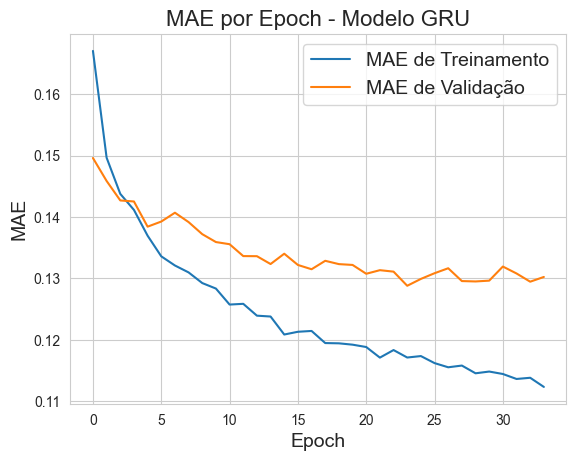

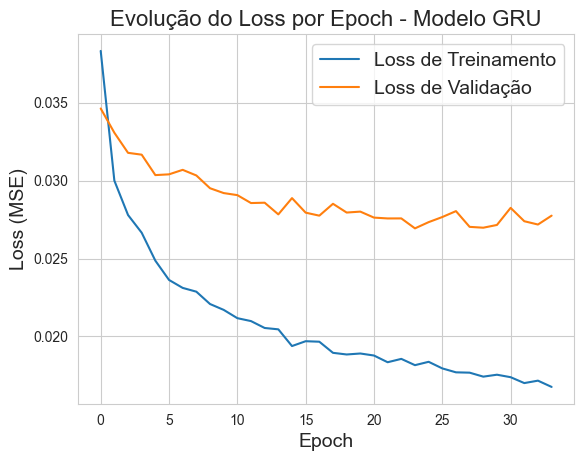

In [87]:
history = model_gru.history.history
plt.plot(history['mae'], label='MAE de Treinamento')
plt.plot(history['val_mae'], label='MAE de Validação')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title("MAE por Epoch - Modelo GRU")
plt.show()

plt.plot(history['loss'], label='Loss de Treinamento')
plt.plot(history['val_loss'], label='Loss de Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Evolução do Loss por Epoch - Modelo GRU")
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
MAE Quadrante 1 (Alegria): 0.12773725390434265
MAE Quadrante 2 (Raiva): 0.13614195585250854
MAE Quadrante 3 (Tristeza): 0.13296911120414734
MAE Quadrante 4 (Calma): 0.11879973113536835


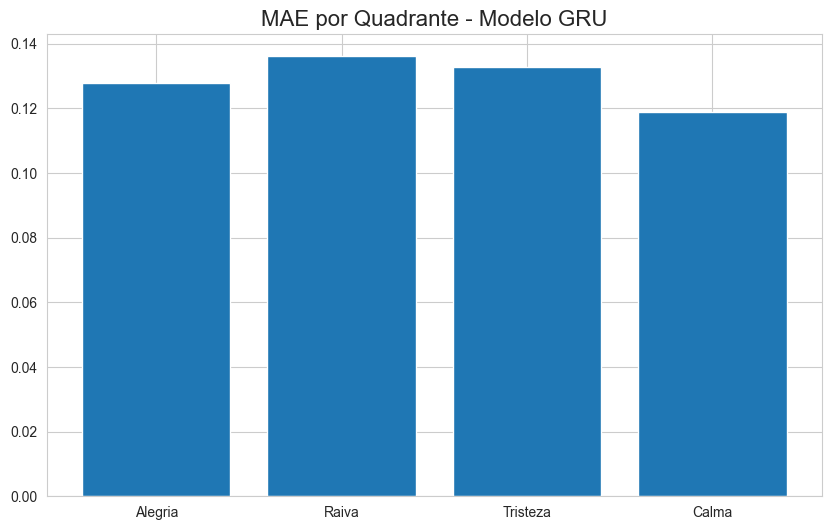

In [88]:
y_pred = model_gru.predict(X_val)

q1_indices_gru = (y_val[:, 0] > 0) & (y_val[:, 1] > 0)  # Alegria
q2_indices_gru = (y_val[:, 0] > 0) & (y_val[:, 1] <= 0)  # Raiva
q3_indices_gru = (y_val[:, 0] <= 0) & (y_val[:, 1] <= 0)  # Tristeza
q4_indices_gru = (y_val[:, 0] <= 0) & (y_val[:, 1] > 0)  # Contentamento

q1_preds_gru, q1_true_gru = y_pred[q1_indices_gru], y_val[q1_indices_gru]
q2_preds_gru, q2_true_gru = y_pred[q2_indices_gru], y_val[q2_indices_gru]
q3_preds_gru, q3_true_gru = y_pred[q3_indices_gru], y_val[q3_indices_gru]
q4_preds_gru, q4_true_gru = y_pred[q4_indices_gru], y_val[q4_indices_gru]

q1_mae_gru = mean_absolute_error(q1_true_gru, q1_preds_gru)
q2_mae_gru = mean_absolute_error(q2_true_gru, q2_preds_gru)
q3_mae_gru = mean_absolute_error(q3_true_gru, q3_preds_gru)
q4_mae_gru = mean_absolute_error(q4_true_gru, q4_preds_gru)

print(f"MAE Quadrante 1 (Alegria): {q1_mae_gru}")
print(f"MAE Quadrante 2 (Raiva): {q2_mae_gru}")
print(f"MAE Quadrante 3 (Tristeza): {q3_mae_gru}")
print(f"MAE Quadrante 4 (Calma): {q4_mae_gru}")

plt.figure(figsize=(10, 6))
plt.bar(['Alegria', 'Raiva', 'Tristeza', 'Calma'], [q1_mae_gru, q2_mae_gru, q3_mae_gru, q4_mae_gru])
plt.title("MAE por Quadrante - Modelo GRU")
plt.show()


In [78]:
# Treinamento
callbacks = [
    ModelCheckpoint("best_model_lstm.keras", save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]
# model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=callbacks)

print("\nIniciando treinamento com sample_weight...")
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weights_train
)

print("Treinamento com pesos concluído.")


Iniciando treinamento com sample_weight...
Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - loss: 0.0907 - mae: 0.2508 - rmse: 0.3127 - val_loss: 0.0469 - val_mae: 0.1767 - val_rmse: 0.2166
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.0483 - mae: 0.1905 - rmse: 0.2348 - val_loss: 0.0454 - val_mae: 0.1741 - val_rmse: 0.2130
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.0431 - mae: 0.1808 - rmse: 0.2210 - val_loss: 0.0443 - val_mae: 0.1719 - val_rmse: 0.2104
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.0401 - mae: 0.1731 - rmse: 0.2133 - val_loss: 0.0436 - val_mae: 0.1702 - val_rmse: 0.2088
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.0385 - mae: 0.1685 - rmse: 0.2080 - val_loss: 0.0408 - val_mae: 0.1638 - val_rmse: 0.2021
Epoch 6/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.0374 - mae: 0.1654 - rmse: 0.2045 - val_loss: 0.0383 - val_mae: 0.1577 - val_rmse: 0.1958
Epoch 7/50
271/271 ━━━━━━━━

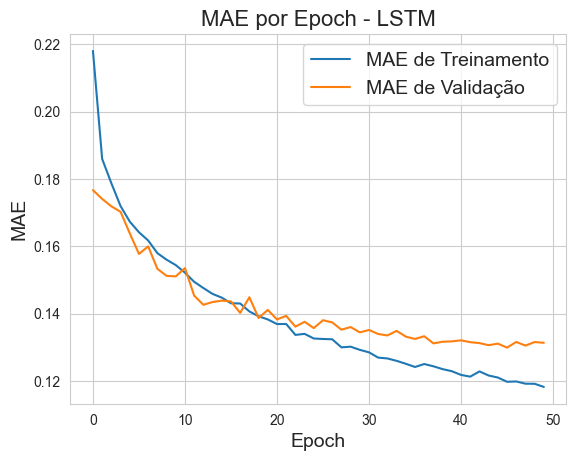

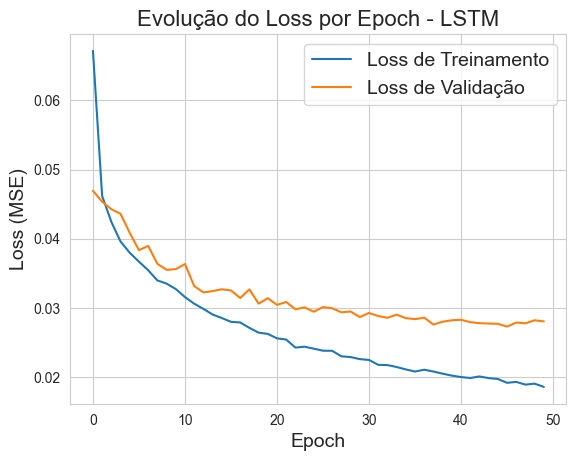

MAE: 0.1313389390707016
LOSS: 0.0280589796602726


In [83]:

plt.rcParams['font.family'] = 'sans-serif'
history_lstm_ = model_lstm.history.history
# plt.xticks(np.arange(0, len(history_lstm_['mae']), 2))
plt.plot(history_lstm_['mae'], label='MAE de Treinamento')
plt.plot(history_lstm_['val_mae'], label='MAE de Validação')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title("MAE por Epoch - LSTM")
plt.show()

# plt.xticks(np.arange(0, len(history_lstm_['loss']), 2))
plt.plot(history_lstm_['loss'], label='Loss de Treinamento')
plt.plot(history_lstm_['val_loss'], label='Loss de Validação')
# indice do X de 1 em 1
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Evolução do Loss por Epoch - LSTM")
plt.show()

print(f"MAE: {history_lstm_['val_mae'][-1]}\nLOSS: {history_lstm_['val_loss'][-1]}")


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
MAE Quadrante 1 (Alegria): 0.1179758757352829
MAE Quadrante 2 (Raiva): 0.1056012213230133
MAE Quadrante 3 (Tristeza): 0.10918973386287689
MAE Quadrante 4 (Contentamento): 0.09394297003746033


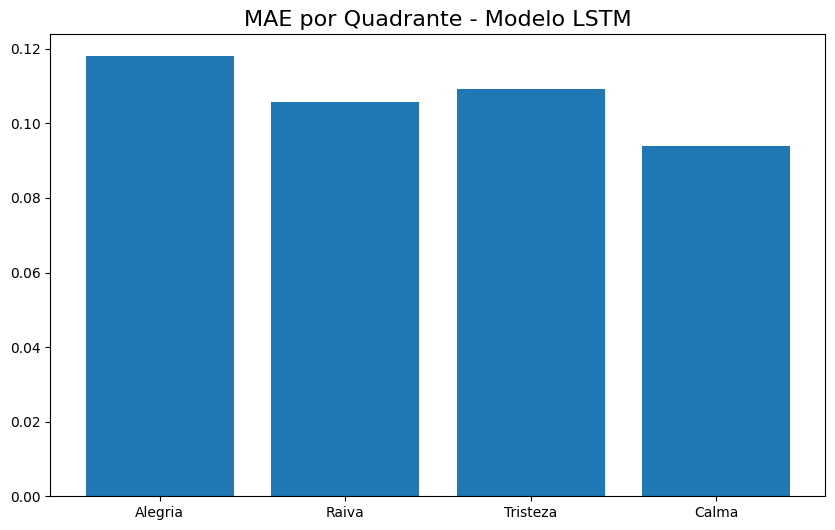

In [62]:
from sklearn.metrics import mean_absolute_error

# Obter as previsões do modelo
y_pred = model_lstm.predict(X_val)

# Definir os quadrantes
q1_indices_lstm = (y_val[:, 0] >= 0) & (y_val[:, 1] >= 0)  # Alegria
q2_indices_lstm = (y_val[:, 0] >= 0) & (y_val[:, 1] < 0)  # Raiva
q3_indices_lstm = (y_val[:, 0] < 0) & (y_val[:, 1] < 0)  # Tristeza
q4_indices_lstm = (y_val[:, 0] < 0) & (y_val[:, 1] >= 0)  # Contentamento

# Filtrar previsões e valores reais para cada quadrante
q1_preds_lstm, q1_true__lstm = y_pred[q1_indices_lstm], y_val[q1_indices_lstm]
q2_preds_lstm, q2_true_lstm = y_pred[q2_indices_lstm], y_val[q2_indices_lstm]
q3_preds_lstm, q3_true_lstm = y_pred[q3_indices_lstm], y_val[q3_indices_lstm]
q4_preds_lstm, q4_true_lstm = y_pred[q4_indices_lstm], y_val[q4_indices_lstm]

# Calcular o MAE para cada quadrante
q1_mae_lstm = mean_absolute_error(q1_true__lstm, q1_preds_lstm)
q2_mae_lstm = mean_absolute_error(q2_true_lstm, q2_preds_lstm)
q3_mae_lstm = mean_absolute_error(q3_true_lstm, q3_preds_lstm)
q4_mae_lstm = mean_absolute_error(q4_true_lstm, q4_preds_lstm)

print(f"MAE Quadrante 1 (Alegria): {q1_mae_lstm}")
print(f"MAE Quadrante 2 (Raiva): {q2_mae_lstm}")
print(f"MAE Quadrante 3 (Tristeza): {q3_mae_lstm}")
print(f"MAE Quadrante 4 (Contentamento): {q4_mae_lstm}")

plt.figure(figsize=(10, 6))
plt.bar(['Alegria', 'Raiva', 'Tristeza', 'Calma'], [q1_mae_lstm, q2_mae_lstm, q3_mae_lstm, q4_mae_lstm])
plt.title("MAE por Quadrante - Modelo LSTM")
plt.show()


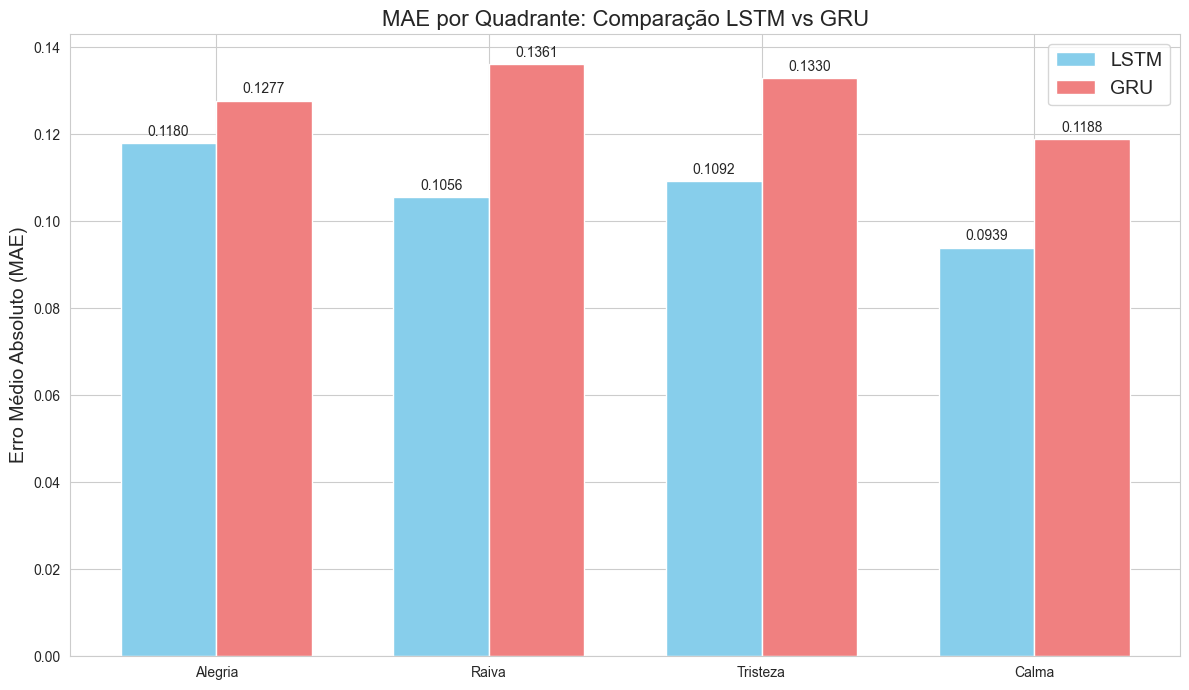

In [89]:
mae_lstm_values = [q1_mae_lstm, q2_mae_lstm, q3_mae_lstm, q4_mae_lstm]
mae_gru_values = [q1_mae_gru, q2_mae_gru, q3_mae_gru, q4_mae_gru]
quadrant_labels = ['Alegria', 'Raiva', 'Tristeza', 'Calma']

x = np.arange(len(quadrant_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

# LSTM Bar
rects1 = ax.bar(x - width/2, mae_lstm_values, width, label='LSTM', color='skyblue')

# GRU Bar
rects2 = ax.bar(x + width/2, mae_gru_values, width, label='GRU', color='lightcoral')

ax.set_ylabel('Erro Médio Absoluto (MAE)')
ax.set_title('MAE por Quadrante: Comparação LSTM vs GRU')
ax.set_xticks(x)
ax.set_xticklabels(quadrant_labels)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')
ax.set_ylim(bottom=0)
fig.tight_layout()
plt.show()

Carregando áudio completo: test/pump_up_the_jam.mp3...
Analisando em segmentos de 5.0 segundos (sem sobreposição)...
Processamento concluído. 44 segmentos analisados.

--- Emoção Geral Média Estimada ---
GRU  (Escala [-1, 1]) -> Arousal: 0.3823, Valence: 0.3329
LSTM (Escala [-1, 1]) -> Arousal: 0.4594, Valence: 0.3410
--------------------
GRU  (Escala [0, 10])  -> Arousal: 6.91, Valence: 6.66
LSTM (Escala [0, 10])  -> Arousal: 7.30, Valence: 6.70

Gerando gráfico temporal das previsões [-1, 1]...


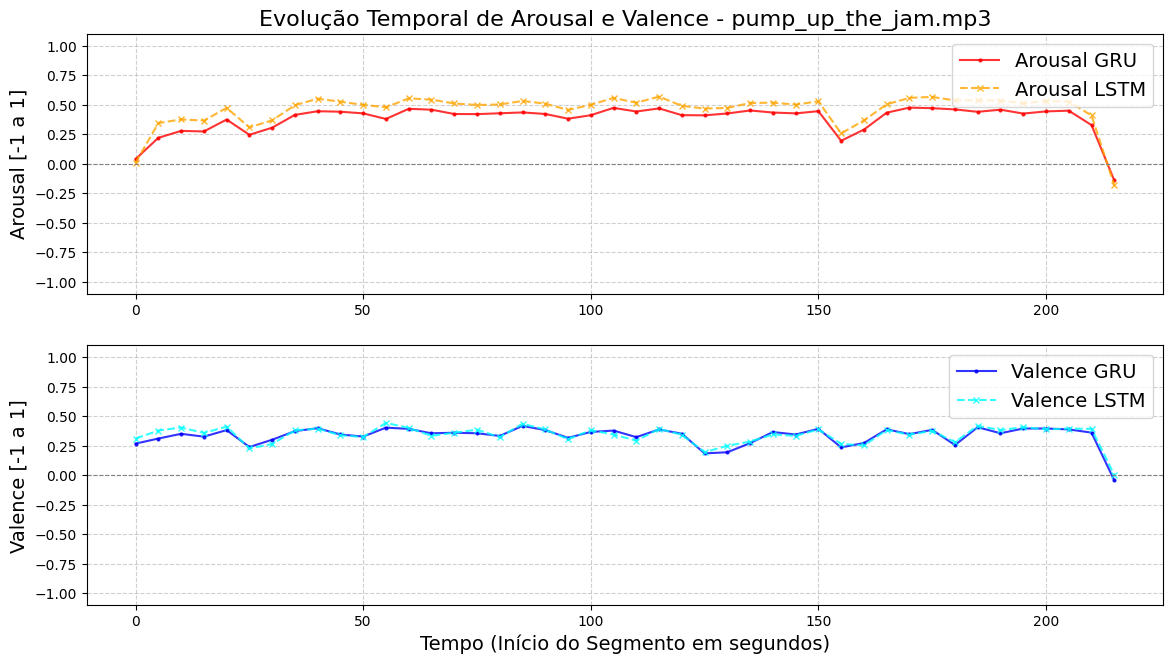


Gerando gráfico da Emoção Geral Média [0, 10]...


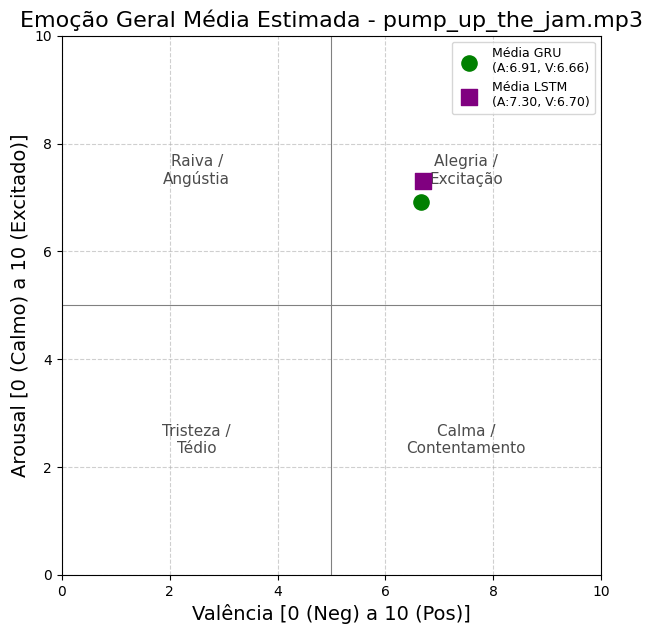

In [28]:
SR = 22050
CLIP_DURATION_SEC = 5.0
TARGET_LENGTH_FRAMES = 216
N_MFCC = 40
N_CHROMA = 12
N_CONTRAST_BANDS = 6
TOTAL_FEATURES = N_MFCC + 1 + 1 + (N_CONTRAST_BANDS + 1) + N_CHROMA + 6 # 67

NEW_AUDIO_PATH = 'test/pump_up_the_jam.mp3'

def pad_or_truncate_time(array_2d, target_length):
    # array_2d shape: (current_frames, n_features)
    current_length = array_2d.shape[0]
    n_features = array_2d.shape[1]
    if current_length == target_length: return array_2d
    if current_length < target_length:
        pad_width = target_length - current_length
        padded_array = np.pad(array_2d, ((0, pad_width), (0, 0)), mode='constant')
    else: # current_length > target_length
        padded_array = array_2d[:target_length, :]
    return padded_array

def load_and_process_features_for_clip(y_clip, sr=SR, n_mfcc=N_MFCC, n_chroma=N_CHROMA, n_contrast_bands=N_CONTRAST_BANDS):

    try:
        if len(y_clip) == 0: return None
        mfcc = librosa.feature.mfcc(y=y_clip, sr=SR, n_mfcc=n_mfcc)
        zcr = librosa.feature.zero_crossing_rate(y=y_clip)
        bw = librosa.feature.spectral_bandwidth(y=y_clip, sr=SR)
        contrast = librosa.feature.spectral_contrast(y=y_clip, sr=SR, n_bands=n_contrast_bands)
        chroma = librosa.feature.chroma_stft(y=y_clip, sr=SR, n_chroma=n_chroma)
        tonnetz = librosa.feature.tonnetz(y=y_clip, sr=sr)
        combined = np.hstack((mfcc.T, zcr.T, bw.T, contrast.T, chroma.T, tonnetz.T ))
        
        return combined
    except Exception as e:
        print(f"Erro extraindo features do clipe: {e}")
        return None

if not os.path.exists(NEW_AUDIO_PATH):
    raise FileNotFoundError(f"Arquivo de áudio não encontrado: {NEW_AUDIO_PATH}")
if 'scaler_x' not in locals() or not hasattr(scaler_x, 'mean_'):
     raise NameError("O objeto 'scaler_x' (StandardScaler) não foi encontrado ou não foi ajustado ('fit').")
if 'model_gru' not in locals() or 'model_lstm' not in locals() :
    raise NameError("Os modelos Keras ('model_gru' e 'model_lstm') não foram encontrados.")

print(f"Carregando áudio completo: {NEW_AUDIO_PATH}...")
try:
    y_full, sr_loaded = librosa.load(NEW_AUDIO_PATH, sr=SR)
    if sr_loaded != SR: print(f"Aviso: Áudio carregado com sr={sr_loaded}, esperado={SR}.")
except Exception as e:
    raise IOError(f"Erro ao carregar o áudio: {e}")

clip_duration_samples = int(CLIP_DURATION_SEC * SR)
hop_samples = clip_duration_samples # Sem sobreposição
gru_predictions_over_time = []
lstm_predictions_over_time = []
timestamps = []

print(f"Analisando em segmentos de {CLIP_DURATION_SEC} segundos (sem sobreposição)...")
num_segments = 0
for start_sample in range(0, len(y_full) - clip_duration_samples + 1, hop_samples):
    end_sample = start_sample + clip_duration_samples
    y_clip = y_full[start_sample:end_sample]
    segment_start_time_sec = start_sample / SR

    try:
        combined_features = load_and_process_features_for_clip(y_clip)
        if combined_features is None: continue

        # Garantir o nº correto de frames (padding/truncating)
        features_padded = pad_or_truncate_time(combined_features, TARGET_LENGTH_FRAMES)
        if features_padded.shape != (TARGET_LENGTH_FRAMES, TOTAL_FEATURES):
             print(f"Aviso: Shape inesperado ({features_padded.shape}) no seg {segment_start_time_sec:.1f}s. Pulando.")
             continue

        # 3. Aplicar StandardScaler (requer reshape)
        features_reshaped = features_padded.reshape(-1, TOTAL_FEATURES)
        features_scaled = scaler_x.transform(features_reshaped)

        # 4. Reshape para o formato do modelo (1, frames, features)
        processed_clip = features_scaled.reshape(1, TARGET_LENGTH_FRAMES, TOTAL_FEATURES)
        processed_clip = processed_clip.astype(np.float32)

        pred_gru = model_gru.predict(processed_clip, verbose=0)[0]   # Saída [-1, 1]
        pred_lstm = model_lstm.predict(processed_clip, verbose=0)[0] # Saída [-1, 1]

        # 6. Guardar predições e timestamp
        gru_predictions_over_time.append(pred_gru)
        lstm_predictions_over_time.append(pred_lstm)
        timestamps.append(segment_start_time_sec)
        num_segments += 1

    except Exception as e:
        print(f"Erro processando segmento em {segment_start_time_sec:.1f}s: {e}")
        continue

print(f"Processamento concluído. {num_segments} segmentos analisados.")

# --- Análise dos Resultados ---
if not timestamps: # Checa se a lista de timestamps está vazia
    print("Nenhuma previsão foi gerada para a música.")
else:
    # Converter listas para arrays NumPy
    gru_preds = np.array(gru_predictions_over_time)
    lstm_preds = np.array(lstm_predictions_over_time)
    timestamps = np.array(timestamps)

    # Calcular Emoção Geral Média para CADA modelo
    mean_arousal_gru = np.mean(gru_preds[:, 0])
    mean_valence_gru = np.mean(gru_preds[:, 1])
    mean_arousal_lstm = np.mean(lstm_preds[:, 0])
    mean_valence_lstm = np.mean(lstm_preds[:, 1])

    # Converter médias para [0, 10]
    mean_arousal_gru_0_10 = ((mean_arousal_gru + 1) / 2) * 10
    mean_valence_gru_0_10 = ((mean_valence_gru + 1) / 2) * 10
    mean_arousal_lstm_0_10 = ((mean_arousal_lstm + 1) / 2) * 10
    mean_valence_lstm_0_10 = ((mean_valence_lstm + 1) / 2) * 10

    print("\n--- Emoção Geral Média Estimada ---")
    print(f"GRU  (Escala [-1, 1]) -> Arousal: {mean_arousal_gru:.4f}, Valence: {mean_valence_gru:.4f}")
    print(f"LSTM (Escala [-1, 1]) -> Arousal: {mean_arousal_lstm:.4f}, Valence: {mean_valence_lstm:.4f}")
    print("-" * 20)
    print(f"GRU  (Escala [0, 10])  -> Arousal: {mean_arousal_gru_0_10:.2f}, Valence: {mean_valence_gru_0_10:.2f}")
    print(f"LSTM (Escala [0, 10])  -> Arousal: {mean_arousal_lstm_0_10:.2f}, Valence: {mean_valence_lstm_0_10:.2f}")

    # --- Plotar Gráfico Temporal com AMBOS os modelos ---
    print("\nGerando gráfico temporal das previsões [-1, 1]...")
    plt.figure(figsize=(12, 7))

    # Arousal
    plt.subplot(2, 1, 1)
    plt.plot(timestamps, gru_preds[:, 0], marker='.', linestyle='-', markersize=4, label='Arousal GRU', color='red', alpha=0.8)
    plt.plot(timestamps, lstm_preds[:, 0], marker='x', linestyle='--', markersize=4, label='Arousal LSTM', color='orange', alpha=0.8)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.ylabel("Arousal [-1 a 1]")
    plt.title(f"Evolução Temporal de Arousal e Valence - {os.path.basename(NEW_AUDIO_PATH)}")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(-1.1, 1.1)

    # Valence
    plt.subplot(2, 1, 2)
    plt.plot(timestamps, gru_preds[:, 1], marker='.', linestyle='-', markersize=4, label='Valence GRU', color='blue', alpha=0.8)
    plt.plot(timestamps, lstm_preds[:, 1], marker='x', linestyle='--', markersize=4, label='Valence LSTM', color='cyan', alpha=0.8)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.ylabel("Valence [-1 a 1]")
    plt.xlabel("Tempo (Início do Segmento em segundos)")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(-1.1, 1.1)

    plt.tight_layout(pad=2.0)
    plt.show()

    # --- Plotar a média geral de AMBOS no quadrante [0, 10] ---
    print("\nGerando gráfico da Emoção Geral Média [0, 10]...")
    plt.figure(figsize=(7, 7))
    plt.axhline(5, color='gray', linestyle='-', linewidth=0.8)
    plt.axvline(5, color='gray', linestyle='-', linewidth=0.8)

    # Plotar os PONTOS das médias gerais rescaladas
    plt.scatter([mean_valence_gru_0_10], [mean_arousal_gru_0_10], color='green', marker='o', s=120, label=f'Média GRU\n(A:{mean_arousal_gru_0_10:.2f}, V:{mean_valence_gru_0_10:.2f})', zorder=5)
    plt.scatter([mean_valence_lstm_0_10], [mean_arousal_lstm_0_10], color='purple', marker='s', s=120, label=f'Média LSTM\n(A:{mean_arousal_lstm_0_10:.2f}, V:{mean_valence_lstm_0_10:.2f})', zorder=5)

    # Rótulos dos quadrantes (escala [0, 10])
    plt.text(7.5, 7.5, 'Alegria /\nExcitação', horizontalalignment='center', verticalalignment='center', fontsize=11, alpha=0.7)
    plt.text(2.5, 7.5, 'Raiva /\nAngústia', horizontalalignment='center', verticalalignment='center', fontsize=11, alpha=0.7)
    plt.text(2.5, 2.5, 'Tristeza /\nTédio', horizontalalignment='center', verticalalignment='center', fontsize=11, alpha=0.7)
    plt.text(7.5, 2.5, 'Calma /\nContentamento', horizontalalignment='center', verticalalignment='center', fontsize=11, alpha=0.7)

    plt.title(f"Emoção Geral Média Estimada - {os.path.basename(NEW_AUDIO_PATH)}")
    plt.xlabel("Valência [0 (Neg) a 10 (Pos)]")
    plt.ylabel("Arousal [0 (Calmo) a 10 (Excitado)]")
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(fontsize=9) # Ajustar tamanho da legenda se necessário
    plt.show()

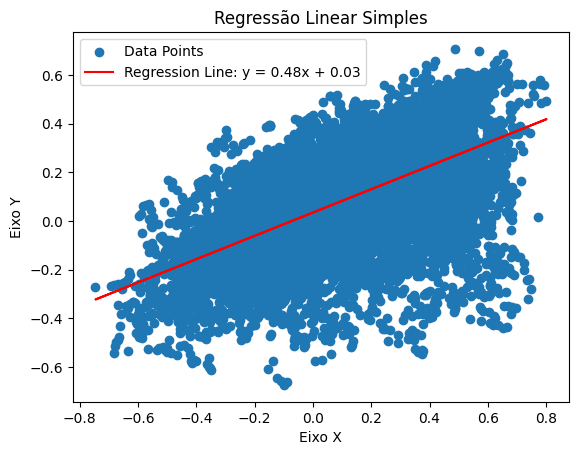

In [52]:
arousal = csv_data['arousal']
valence = csv_data['valence']

m, c = np.polyfit(arousal, valence, 1)

valence_predicted = m * arousal + c
plt.scatter(arousal, valence, label='Data Points')
plt.plot(arousal, valence_predicted, color='red', label=f'Regression Line: y = {m:.2f}x + {c:.2f}')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Regressão Linear Simples')
plt.legend()
plt.show()

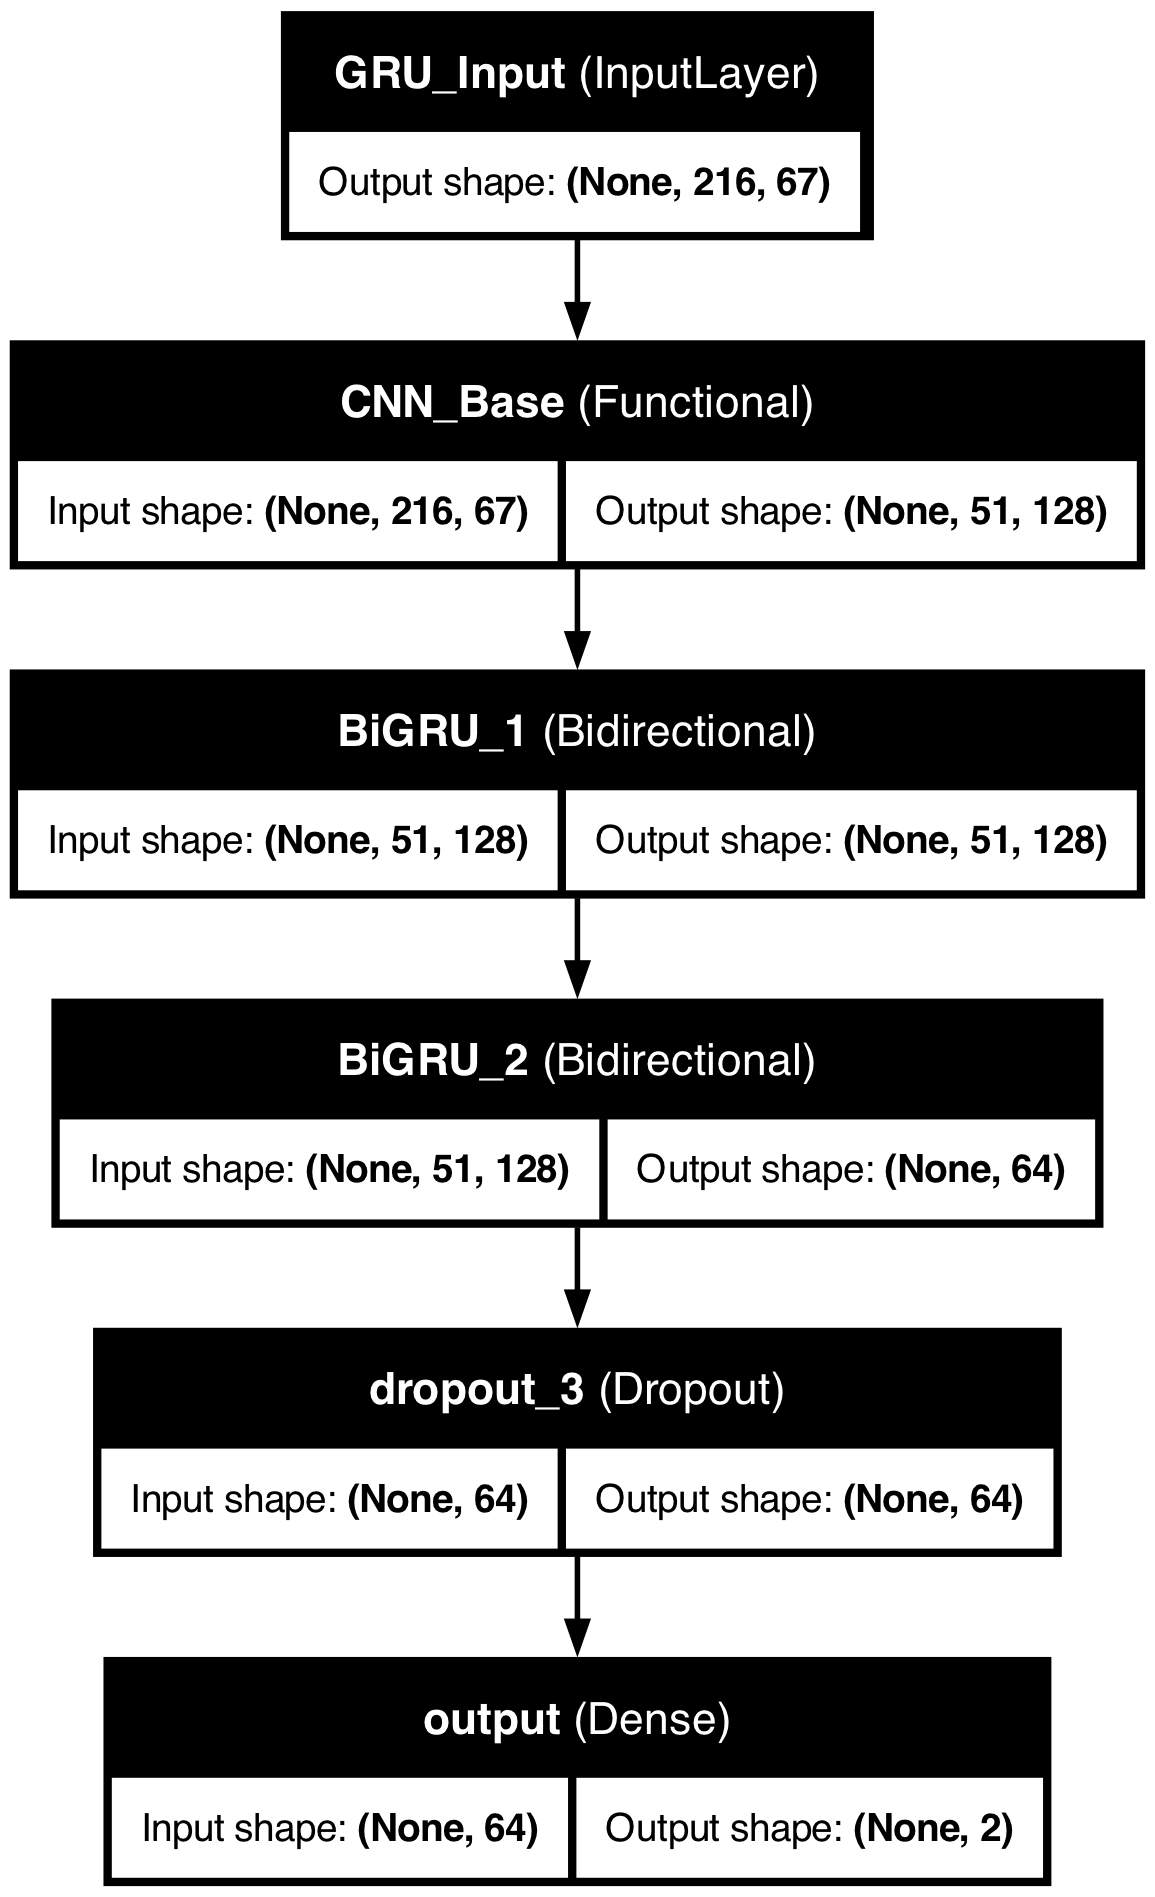

In [67]:
from tensorflow import keras
# Assumindo que model_gru está definido e compilado
keras.utils.plot_model(
    model_gru,
    to_file='model_gru_architecture.png', # Salva a imagem
    show_shapes=True, # Mostra os shapes de entrada/saída
    show_layer_names=True, # Mostra os nomes das camadas
    # rankdir='TB', # TB=Top-to-Bottom, LR=Left-to-Right
    # expand_nested=True # Se usar modelos aninhados
)

Gerando Scatter Plot com dados reais...


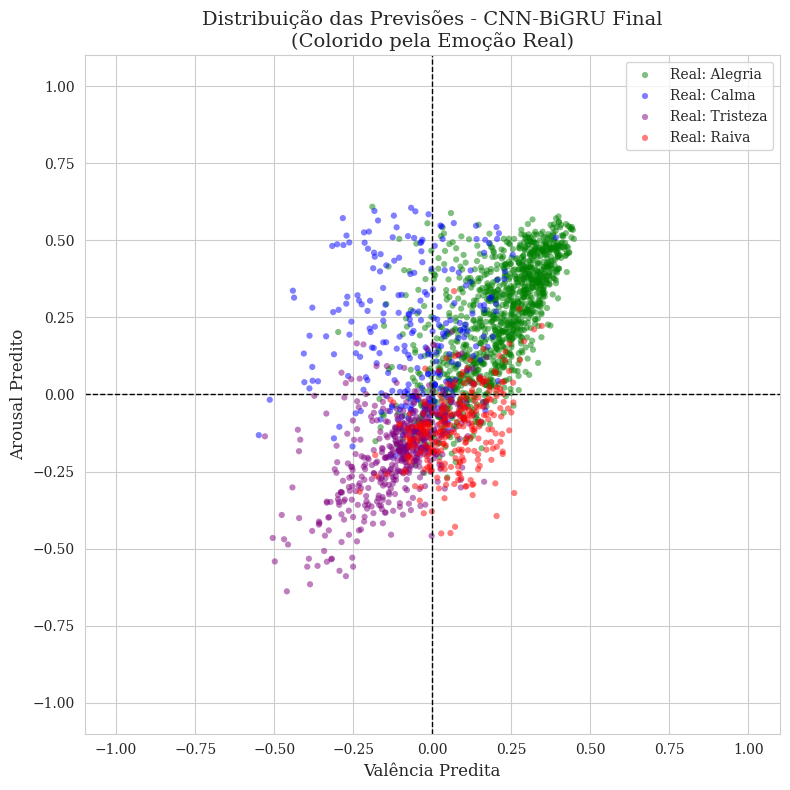

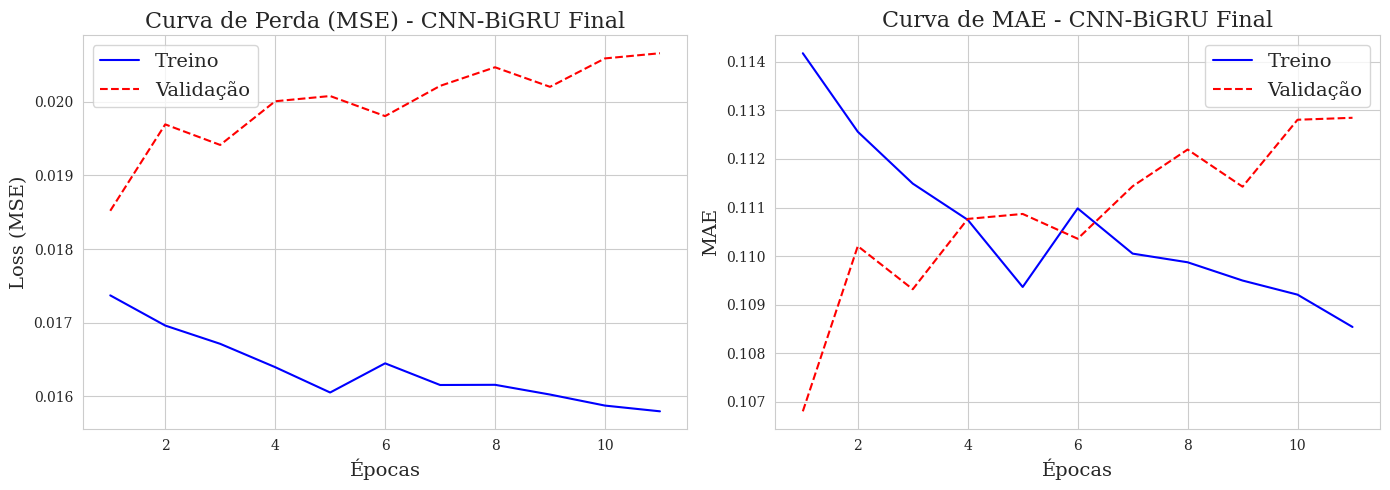

Gerando Scatter Plot com dados reais...


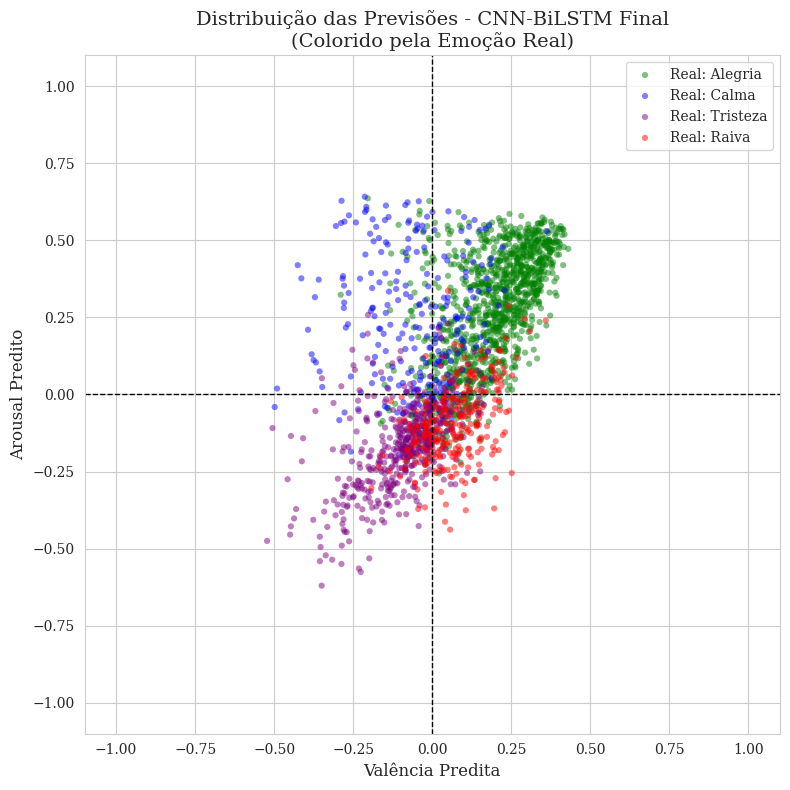

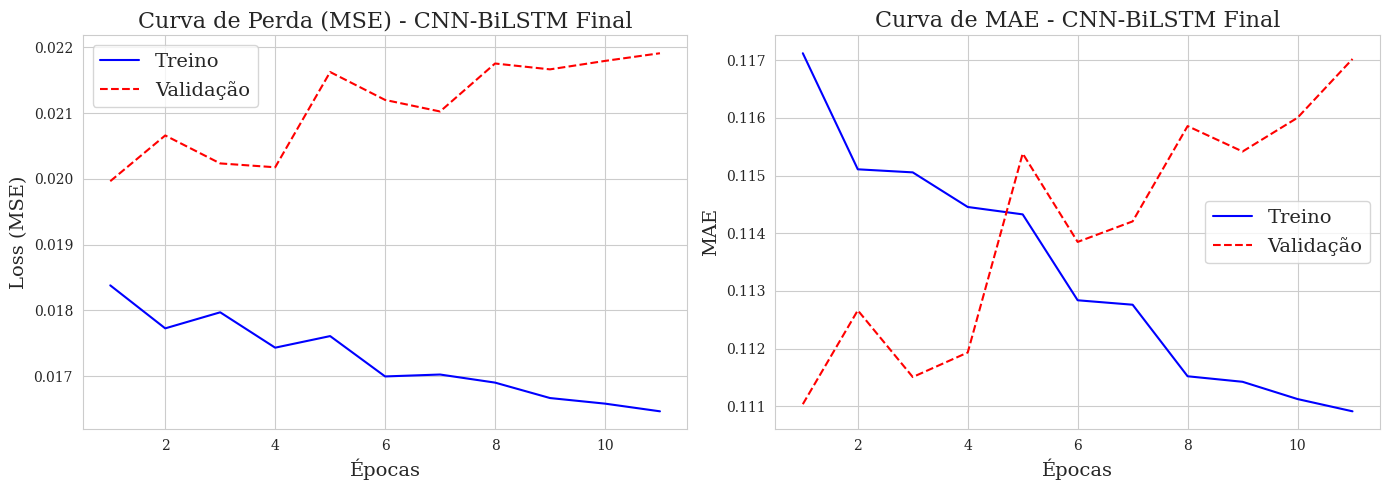

In [ ]:
sns.set_style("whitegrid")
# plt.rcParams['font.family'] = 'serif' # Fonte mais acadêmica

# --- Função para Scatter Plot Colorido por Classe Real ---
def plot_scatter_predictions(y_true, y_pred, model_name):
    """
    Plota as previsões no espaço Arousal-Valência, coloridas pela classe REAL.
    Isso ajuda a ver onde os pontos de cada emoção foram parar.
    """
    # Definir cores para cada quadrante real
    # Q1: Alegria (Verde), Q2: Calma (Azul), Q3: Tristeza (Roxo), Q4: Raiva (Vermelho)
    colors = []
    labels = []
    
    for i in range(len(y_true)):
        v, a = y_true[i]
        if v >= 0 and a > 0:
            colors.append('green') # Alegria
            labels.append('Real: Alegria')
        elif v >= 0 and a <= 0:
            colors.append('blue') # Calma
            labels.append('Real: Calma')
        elif v < 0 and a <= 0:
            colors.append('purple') # Tristeza
            labels.append('Real: Tristeza')
        else:
            colors.append('red') # Raiva
            labels.append('Real: Raiva')

    plt.figure(figsize=(8, 8))
    
    # Plotar pontos
    # Usamos um loop para criar a legenda corretamente (um ponto fake para cada cor)
    unique_labels = ['Real: Alegria', 'Real: Calma', 'Real: Tristeza', 'Real: Raiva']
    unique_colors = ['green', 'blue', 'purple', 'red']
    
    for label, color in zip(unique_labels, unique_colors):
        # Filtrar pontos dessa classe
        indices = [i for i, x in enumerate(labels) if x == label]
        if indices:
            plt.scatter(y_pred[indices, 1], y_pred[indices, 0], 
                        c=color, label=label, alpha=0.5, s=20, edgecolors='none')

    # Linhas de referência
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.title(f'Distribuição das Previsões - {model_name}\n(Colorido pela Emoção Real)', fontsize=14)
    plt.xlabel('Valência Predita', fontsize=12)
    plt.ylabel('Arousal Predito', fontsize=12)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

# --- Função para Curvas de Aprendizado (Simulada para Exemplo) ---
def plot_learning_curves(history_dict, model_name):
    """
    Plota as curvas de Loss e MAE.
    history_dict: Dicionário com chaves 'loss', 'val_loss', 'mae', 'val_mae'
    """
    epochs = range(1, len(history_dict['loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de Loss
    ax1.plot(epochs, history_dict['loss'], 'b-', label='Treino')
    ax1.plot(epochs, history_dict['val_loss'], 'r--', label='Validação')
    ax1.set_title(f'Curva de Perda (MSE) - {model_name}')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfico de MAE
    ax2.plot(epochs, history_dict['mae'], 'b-', label='Treino')
    ax2.plot(epochs, history_dict['val_mae'], 'r--', label='Validação')
    ax2.set_title(f'Curva de MAE - {model_name}')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Bloco de Execução ---
def run_final_plots(model, X_val, y_val, history_gru, model_name):
    # Tenta obter dados reais do ambiente
    print("Gerando Scatter Plot com dados reais...")
    y_pred = model.predict(X_val, verbose=0)
    plot_scatter_predictions(y_val, y_pred, model_name)

    # Tenta obter histórico real
    # (Normalmente o objeto 'history' do keras.fit retorna um .history dict)
    plot_learning_curves(history_gru.history, model_name)
run_final_plots(model_gru, X_val, y_val, history_gru, "CNN-BiGRU Final")
run_final_plots(model_lstm, X_val, y_val, history_lstm, "CNN-BiLSTM Final")